In [1]:
import pandas as pd
import numpy as np

# === 1) Load & bersihkan ===
df = pd.read_excel("Data pertandingan19-25.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()

# anggap '', 'nan', 'none' sebagai missing
df.loc[df["HomeTeam"].str.lower().isin(["", "nan", "none"]), "HomeTeam"] = np.nan
df.loc[df["AwayTeam"].str.lower().isin(["", "nan", "none"]), "AwayTeam"] = np.nan
df = df.dropna(subset=["HomeTeam","AwayTeam"]).reset_index(drop=True)

# --- Normalisasi nama tim biar konsisten ---
df["HomeTeam"] = (
    df["HomeTeam"].str.strip()
    .str.title()
    .replace({
        "Ath Madrid": "Atletico Madrid",
        "Ath Bilbao": "Athletic Bilbao",
        "Betis": "Real Betis",
        "Espanol": "RCD Espanyol",
        # tambahkan jika ada singkatan lain
    })
)

df["AwayTeam"] = (
    df["AwayTeam"].str.strip()
    .str.title()
    .replace({
        "Ath Madrid": "Atletico Madrid",
        "Ath Bilbao": "Athletic Bilbao",
        "Betis": "Real Betis",
        "Espanol": "RCD Espanyol",
    })
)


# === 2) Daftar tim unik ===
teams = sorted(pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]], ignore_index=True)))

# === 3) Mapping: NAIK 1 (mulai dari 1) ===
team_id = {team: i+1 for i, team in enumerate(teams)}   # 1-based IDs
id_team = {i: team for team, i in team_id.items()}

# Tambahkan kolom ID ke dataframe (1-based)
df["HomeID"] = df["HomeTeam"].map(team_id).astype(int)
df["AwayID"] = df["AwayTeam"].map(team_id).astype(int)

# === 4) Cek hasil ===
print("Jumlah tim unik:", len(teams))
print("Contoh mapping (10 pertama):", list(team_id.items())[:10])
print(df[["HomeTeam","AwayTeam","HomeID","AwayID"]].head())

# === 5) Simpan output ===
# a) Tabel mapping id ↔ name (mulai 1)
map_df = pd.DataFrame({"id": range(1, len(teams)+1), "name": teams})
map_df.to_csv("team_mapping_id1.csv", index=False, encoding="utf-8")

# b) Dataset pertandingan dengan kolom HomeID/AwayID 1-based
df.to_excel("matches_with_ids.xlsx", index=False)


Jumlah tim unik: 27
Contoh mapping (10 pertama): [('Alaves', 1), ('Almeria', 2), ('Athletic Bilbao', 3), ('Atletico Madrid', 4), ('Barcelona', 5), ('Cadiz', 6), ('Celta', 7), ('Eibar', 8), ('Elche', 9), ('Getafe', 10)]
          HomeTeam     AwayTeam  HomeID  AwayID
0  Athletic Bilbao    Barcelona       3       5
1            Celta  Real Madrid       7      21
2         Valencia     Sociedad      24      23
3         Mallorca        Eibar      17       8
4          Leganes      Osasuna      15      18


In [1]:
# =============================================
#BHM dan NB
# =============================================

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

# =======================
# CONFIG
# =======================
LIKELIHOOD = "nb"   # "poisson" atau "nb"
USE_SCALING = True
FULL_FEATS  = ["HST","AST","HS","AS","HC","AC","HY","AY","HR","AR","hst","ast","hs","aws","hc","ac","hy","ay","hr","ar"]
HT_FEATS    = ["HTHG","HTAG","hthg","htag"]
DRAWS = 800; TUNE = 800

# =======================
# 1️ LOAD & PREPROCESS
# =======================
df = pd.read_excel("Data pertandingan19-25.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

col_home_id = "HomeID" if "HomeID" in df.columns else ("home_id" if "home_id" in df.columns else None)
col_away_id = "AwayID" if "AwayID" in df.columns else ("away_id" if "away_id" in df.columns else None)
if col_home_id is None or col_away_id is None:
    raise ValueError("Dataset harus punya kolom HomeID/AwayID (atau home_id/away_id).")

df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
    df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()

df = df.dropna(subset=["HomeID","AwayID"]).reset_index(drop=True)
df["HomeID"] = df["HomeID"].astype(int)
df["AwayID"] = df["AwayID"].astype(int)

g_home_col = "FTHG" if "FTHG" in df.columns else ("fthg" if "fthg" in df.columns else None)
g_away_col = "FTAG" if "FTAG" in df.columns else ("ftag" if "ftag" in df.columns else None)
df["FTHG"] = pd.to_numeric(df[g_home_col], errors="coerce")
df["FTAG"] = pd.to_numeric(df[g_away_col], errors="coerce")
df = df.loc[df["FTHG"].notna() & df["FTAG"].notna()].copy()

# alias fitur
_alias = {
    "hst":"HST","ast":"AST","hs":"HS","aws":"AS","hc":"HC","ac":"AC",
    "hy":"HY","ay":"AY","hr":"HR","ar":"AR",
    "hthg":"HTHG","htag":"HTAG"
}
for low, up in _alias.items():
    if low in df.columns and up not in df.columns:
        df[up] = pd.to_numeric(df[low], errors="coerce").fillna(0)
for up in set(_alias.values()):
    if up in df.columns:
        df[up] = pd.to_numeric(df[up], errors="coerce").fillna(0)
for c in set([c.upper() for c in FULL_FEATS] + [c.upper() for c in HT_FEATS]):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

if USE_SCALING:
    from sklearn.preprocessing import StandardScaler
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df.columns]
    if H_cols: df[H_cols] = StandardScaler().fit_transform(df[H_cols])
    if A_cols: df[A_cols] = StandardScaler().fit_transform(df[A_cols])

# =======================
# 2️ DATA BUILDERS
# =======================
unique_ids = np.unique(np.concatenate([df["HomeID"].values, df["AwayID"].values]))
unique_ids = np.sort(unique_ids)
id_to_idx = {tid: i for i, tid in enumerate(unique_ids)}
idx_to_id = {i: tid for tid, i in id_to_idx.items()}

id_to_name = None
if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    name_map = {}
    for _, r in df[["HomeID","HomeTeam"]].dropna().iterrows():
        name_map[int(r["HomeID"])] = str(r["HomeTeam"])
    for _, r in df[["AwayID","AwayTeam"]].dropna().iterrows():
        name_map.setdefault(int(r["AwayID"]), str(r["AwayTeam"]))
    id_to_name = {tid: name_map.get(tid, f"Team_{tid}") for tid in unique_ids}

def split_feats_available(df_):
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df_.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df_.columns]
    return H_cols, A_cols

def build_data(df_):
    H_full, A_full = split_feats_available(df_)
    return {
        "team_ids": unique_ids,
        "id_to_idx": id_to_idx,
        "idx_to_id": idx_to_id,
        "id_to_name": id_to_name,
        "home_idx": df_["HomeID"].map(id_to_idx).values.astype("int32"),
        "away_idx": df_["AwayID"].map(id_to_idx).values.astype("int32"),
        "goals_home": df_["FTHG"].values.astype("int32"),
        "goals_away": df_["FTAG"].values.astype("int32"),
        "H_full": H_full, "A_full": A_full,
        "XH_full": df_[H_full].values.astype("float32") if H_full else None,
        "XA_full": df_[A_full].values.astype("float32") if A_full else None,
        "HTHG": df_["HTHG"].values.astype("float32") if "HTHG" in df_.columns else None,
        "HTAG": df_["HTAG"].values.astype("float32") if "HTAG" in df_.columns else None,
    }

data_full = build_data(df)

# =======================
# 3️ BUILD MODEL
# =======================
def build_model(data, mode="full", likelihood=LIKELIHOOD):
    n_teams = len(data["team_ids"])
    coords = {"team": np.arange(n_teams),
              "feat_H": np.arange(len(data["H_full"])),
              "feat_A": np.arange(len(data["A_full"])),
              "match": np.arange(len(data["home_idx"]))}
    with pm.Model(coords=coords) as model:
        sigma_att = pm.Exponential("sigma_att", 1.0)
        sigma_def = pm.Exponential("sigma_def", 1.0)
        attack_raw  = pm.Normal("attack_raw", 0, sigma_att, dims="team")
        defense_raw = pm.Normal("defense_raw", 0, sigma_def, dims="team")
        attack  = pm.Deterministic("attack",  attack_raw  - pt.mean(attack_raw))
        defense = pm.Deterministic("defense", defense_raw - pt.mean(defense_raw))
        home_adv = pm.Normal("home_adv", mu=0.10, sigma=0.10)

        lin_home = home_adv + attack[data["home_idx"]] - defense[data["away_idx"]]
        lin_away =            attack[data["away_idx"]] - defense[data["home_idx"]]

        if mode == "full" and data["XH_full"] is not None and data["XA_full"] is not None:
            betaH = pm.Normal("beta_full_H", 0, 0.5, dims="feat_H")
            betaA = pm.Normal("beta_full_A", 0, 0.5, dims="feat_A")
            lin_home += pt.dot(data["XH_full"], betaH) + pt.dot(data["XA_full"], betaA)
            lin_away += pt.dot(data["XA_full"], betaH) + pt.dot(data["XH_full"], betaA)

        mu_home = pm.Deterministic("mu_home", pt.exp(lin_home))
        mu_away = pm.Deterministic("mu_away", pt.exp(lin_away))

        if likelihood == "poisson":
            pm.Poisson("y_home", mu=mu_home, observed=data["goals_home"])
            pm.Poisson("y_away", mu=mu_away, observed=data["goals_away"])
        else:
            alpha = pm.Exponential("alpha", 2.0)
            pm.NegativeBinomial("y_home", mu=mu_home, alpha=alpha, observed=data["goals_home"])
            pm.NegativeBinomial("y_away", mu=mu_away, alpha=alpha, observed=data["goals_away"])
    return model

def sample_model(model, draws=DRAWS, tune=TUNE, target_accept=0.9, random_seed=42):
    with model:
        return pm.sample(draws=draws, tune=tune, target_accept=target_accept, random_seed=random_seed)

# =======================
# 4️⃣ TRAIN FULL MODEL
# =======================
print("⏳ Training full BHM...")
model_full = build_model(data_full, mode="full", likelihood=LIKELIHOOD)
trace_full = sample_model(model_full, random_seed=11)
print("✅ alpha mean =", float(trace_full.posterior["alpha"].mean()))

# =======================
# 5️⃣ DEFINE HELPERS (xG & TIER)
# =======================
def build_team_strength_from_xg(df):
    if "HST" not in df or "AST" not in df:
        raise ValueError("Butuh kolom HST dan AST.")
    df["xg_home"], df["xg_away"] = df["HST"], df["AST"]
    hids, aids = df["HomeID"], df["AwayID"]
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)
    id2idx = {tid: i for i, tid in enumerate(teams)}
    m = len(df)*2; p = 2+2*n
    X = np.zeros((m,p)); y = np.zeros(m)
    r=0
    for _,row in df.iterrows():
        hi=id2idx[row["HomeID"]]; ai=id2idx[row["AwayID"]]
        xgh=row["xg_home"]; xga=row["xg_away"]
        X[r,[0,1,2+hi,2+n+ai]]=[1,1,1,-1]; y[r]=xgh; r+=1
        X[r,[0,2+ai,2+n+hi]]=[1,1,-1]; y[r]=xga; r+=1
    lam=1e-3; A=X.T@X+lam*np.eye(p); b=X.T@y; coef=np.linalg.solve(A,b)
    att=coef[2:2+n]; dff=coef[2+n:]; idx2id={i:t for t,i in id2idx.items()}
    return {idx2id[i]:float(att[i]-dff[i]) for i in range(n)}, None

def quality_gap_and_tier(ratings, home_id, away_id):
    gap = ratings.get(home_id,0)-ratings.get(away_id,0)
    vals=np.array(list(ratings.values()))
    med=np.median(vals); mad=np.median(np.abs(vals-med))+1e-9
    gap_scaled=gap/(1.4826*mad)
    g=abs(gap_scaled)
    if g>=1.2:tier="big_vs_small"
    elif g>=0.6:tier="big_vs_mid"
    elif g>=0.25:tier="mid_vs_small"
    else:tier="balanced"
    return gap,gap_scaled,tier

# =======================
# 6️⃣ NEW HT MODEL (LIVE XG ONLY)
def predict_probs_by_id(trace, data, home_id, away_id, mode="full", likelihood=LIKELIHOOD):
    """Hitung probabilitas menang/seri/kalah + xG mean per tim."""
    att = trace.posterior["attack"].values   # shape (chain, draw, team)
    dff = trace.posterior["defense"].values
    hadv = trace.posterior["home_adv"].values

    hidx = data["id_to_idx"][home_id]
    aidx = data["id_to_idx"][away_id]

    # log-lambda / linear predictor
    lin_home = hadv + att[:,:,hidx] - dff[:,:,aidx]
    lin_away =        att[:,:,aidx] - dff[:,:,hidx]

    muH = np.exp(lin_home)
    muA = np.exp(lin_away)

    # Mean xG
    mu_home_mean = float(muH.mean())
    mu_away_mean = float(muA.mean())

    # Simulate goals
    n_samp = muH.size
    lamH = muH.reshape(-1)
    lamA = muA.reshape(-1)

    if likelihood == "nb" or likelihood == "negative_binomial":
        alpha = float(trace.posterior["alpha"].mean())
        goalsH = np.random.negative_binomial(alpha, alpha/(alpha+lamH))
        goalsA = np.random.negative_binomial(alpha, alpha/(alpha+lamA))
    else:
        goalsH = np.random.poisson(lamH)
        goalsA = np.random.poisson(lamA)

    # Probabilitas
    winH = np.mean(goalsH > goalsA)
    draw = np.mean(goalsH == goalsA)
    winA = np.mean(goalsH < goalsA)

    return {
        "p_home": float(winH),
        "p_draw": float(draw),
        "p_away": float(winA),
        "mu_home_mean": mu_home_mean,
        "mu_away_mean": mu_away_mean,
    }

    
def predict_by_id_ht(home_id, away_id, hthg, htag):
    """
    Versi HT (Half-Time) baru yang pakai blending xG-only tanpa menit.
    """
    ratings, _ = build_team_strength_from_xg(df)
    pre = predict_probs_by_id(trace_full, data_full, home_id, away_id, mode="full")
    gap_raw, gap_scaled, tier = quality_gap_and_tier(ratings, home_id, away_id)
    lead = abs(hthg - htag)

    w_live_base = np.clip(1.0 - np.tanh(0.6 * abs(gap_scaled)), 0.1, 1.0)
    w_live = np.clip(w_live_base + 0.2 * lead, 0.0, 1.0)
    w_pre = 1.0 - w_live

    pH = w_pre * pre["p_home"] + w_live * (0.55 if hthg > htag else 0.25)
    pD = w_pre * pre["p_draw"] + w_live * (0.5 if hthg == htag else 0.2)
    pA = w_pre * pre["p_away"] + w_live * (0.55 if htag > hthg else 0.25)
    s = pH + pD + pA + 1e-9
    pH, pD, pA = pH/s, pD/s, pA/s

    muH = w_pre * pre["mu_home_mean"] + w_live * (pre["mu_home_mean"] + hthg)
    muA = w_pre * pre["mu_away_mean"] + w_live * (pre["mu_away_mean"] + htag)

    return {
        "home_id": home_id,
        "away_id": away_id,
        "p_home": float(pH),
        "p_draw": float(pD),
        "p_away": float(pA),
        "mu_home_mean": float(muH),
        "mu_away_mean": float(muA),
        "gap_xg": float(gap_raw),
        "gap_xg_scaled": float(gap_scaled),
        "tier": tier,
        "w_live": float(w_live),
        "w_pre": float(w_pre),
    }

# =======================
# 7. Testing
# =======================


print("\n=== TEST: FULL MATCH ===")
print(predict_probs_by_id(trace_full, data_full, home_id=1, away_id=16, mode="full"))

print("\n=== TEST: HALF-TIME (LIVE XG ONLY) ===")
res_ht = predict_by_id_ht(home_id=1, away_id=5, hthg=2, htag=1)
print(res_ht)


⏳ Training full BHM...


Initializing NUTS using jitter+adapt_diag...
C:\Users\aldoh\anaconda3\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 132 seconds.


✅ alpha mean = 22.573011045245433

=== TEST: FULL MATCH ===
{'p_home': 0.395625, 'p_draw': 0.2915625, 'p_away': 0.3128125, 'mu_home_mean': 1.1976600319160269, 'mu_away_mean': 1.0286051980749846}

=== TEST: HALF-TIME (LIVE XG ONLY) ===
{'home_id': 1, 'away_id': 5, 'p_home': 0.32928124967071876, 'p_draw': 0.2457187497542812, 'p_away': 0.42499999957499995, 'mu_home_mean': 1.5336427043059655, 'mu_away_mean': 1.7844283967527108, 'gap_xg': -0.8156429604780671, 'gap_xg_scaled': -3.6232027775630993, 'tier': 'big_vs_small', 'w_live': 0.30000000000000004, 'w_pre': 0.7}


In [2]:
# =========================================================
# 8. Tambah kolom musim (season)
# =========================================================
def add_season(df):
    d = df.copy()
    d["Date"] = pd.to_datetime(d["Date"])
    seasons = []
    for t in d["Date"]:
        y, m = t.year, t.month
        if m >= 7:
            seasons.append(f"{y}/{y+1}")
        else:
            seasons.append(f"{y-1}/{y}")
    d["season"] = seasons
    return d


# =========================================================
# 9. Evaluasi BHM untuk satu musim (train = musim lain, test = musim ini)
# =========================================================
def evaluate_season_bhm(df_train, df_test, draws=DRAWS, tune=TUNE):
    """
    Train BHM di df_train, lalu uji di df_test (klasifikasi H/D/A).
    """
    # siapkan data train
    data_train = build_data(df_train)

    # bangun dan sampling model
    print(f"  Training BHM di {len(df_train)} pertandingan...")
    model = build_model(data_train, mode="full", likelihood=LIKELIHOOD)
    trace = sample_model(model, draws=draws, tune=tune, target_accept=0.9, random_seed=42)

    # evaluasi di df_test
    probs = []
    y_idx = []   # 0=H, 1=D, 2=A

    for _, row in df_test.iterrows():
        home_id = int(row["HomeID"])
        away_id = int(row["AwayID"])

        res = predict_probs_by_id(trace, data_train, home_id, away_id, mode="full", likelihood=LIKELIHOOD)
        pH, pD, pA = res["p_home"], res["p_draw"], res["p_away"]
        probs.append([pH, pD, pA])

        gh, ga = int(row["FTHG"]), int(row["FTAG"])
        if gh > ga:
            y_idx.append(0)
        elif gh == ga:
            y_idx.append(1)
        else:
            y_idx.append(2)

    probs = np.array(probs)            # (N,3)
    y_idx = np.array(y_idx)            # (N,)

    # prediksi kelas
    pred_idx = probs.argmax(axis=1)
    acc = (pred_idx == y_idx).mean()

    # logloss multi-class
    eps = 1e-12
    ll = -np.mean(np.log(probs[np.arange(len(y_idx)), y_idx] + eps))

    # Brier multi-class
    one_hot = np.eye(3)[y_idx]         # (N,3)
    brier = np.mean(np.sum((probs - one_hot)**2, axis=1))

    return acc, ll, brier, len(df_test)

# =========================================================
# 10. LOSO: 5 musim latih, 1 musim uji (diulang untuk semua musim)
# =========================================================
print("\n=== LOSO BHM PER MUSIM (5 TRAIN, 1 TEST) ===")

df_season = add_season(df)
all_seasons = sorted(df_season["season"].unique())

results = []

for S in all_seasons:
    print(f"\n>> Season {S} sebagai TEST")

    df_test  = df_season[df_season["season"] == S].copy()
    df_train = df_season[df_season["season"] != S].copy()

    acc, ll, brier, n = evaluate_season_bhm(df_train, df_test)

    print(f"  Jumlah pertandingan test : {n}")
    print(f"  Accuracy H/D/A           : {acc*100:.2f}%")
    print(f"  Logloss                  : {ll:.4f}")
    print(f"  Brier Score              : {brier:.4f}")

    results.append([S, n, acc, ll, brier])

# rangkum ke DataFrame
res_bhm = pd.DataFrame(results, columns=["Season","N","Accuracy","Logloss","Brier"])
print("\n=== RINGKASAN LOSO BHM ===")
print(res_bhm)

print("\n=== RATA-RATA 6 MUSIM (BHM) ===")
print(f"Accuracy rata-rata : {res_bhm['Accuracy'].mean()*100:.2f}%")
print(f"Logloss rata-rata  : {res_bhm['Logloss'].mean():.4f}")
print(f"Brier rata-rata    : {res_bhm['Brier'].mean():.4f}")



=== LOSO BHM PER MUSIM (5 TRAIN, 1 TEST) ===

>> Season 2018/2019 sebagai TEST
  Training BHM di 2250 pertandingan...


C:\Users\aldoh\AppData\Local\Temp\ipykernel_19028\4077372443.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 82 seconds.


  Jumlah pertandingan test : 30
  Accuracy H/D/A           : 36.67%
  Logloss                  : 1.0428
  Brier Score              : 0.6276

>> Season 2019/2020 sebagai TEST
  Training BHM di 1965 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 75 seconds.


  Jumlah pertandingan test : 315
  Accuracy H/D/A           : 49.52%
  Logloss                  : 1.0210
  Brier Score              : 0.6119

>> Season 2020/2021 sebagai TEST
  Training BHM di 1890 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 74 seconds.


  Jumlah pertandingan test : 390
  Accuracy H/D/A           : 50.51%
  Logloss                  : 1.0258
  Brier Score              : 0.6146

>> Season 2021/2022 sebagai TEST
  Training BHM di 1898 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 78 seconds.


  Jumlah pertandingan test : 382
  Accuracy H/D/A           : 49.48%
  Logloss                  : 1.0343
  Brier Score              : 0.6217

>> Season 2022/2023 sebagai TEST
  Training BHM di 1878 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 74 seconds.


  Jumlah pertandingan test : 402
  Accuracy H/D/A           : 52.99%
  Logloss                  : 1.0022
  Brier Score              : 0.5985

>> Season 2023/2024 sebagai TEST
  Training BHM di 1899 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 74 seconds.


  Jumlah pertandingan test : 381
  Accuracy H/D/A           : 48.29%
  Logloss                  : 1.0277
  Brier Score              : 0.6166

>> Season 2024/2025 sebagai TEST
  Training BHM di 1942 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 76 seconds.


  Jumlah pertandingan test : 338
  Accuracy H/D/A           : 48.52%
  Logloss                  : 1.0259
  Brier Score              : 0.6148

>> Season 2025/2026 sebagai TEST
  Training BHM di 2238 pertandingan...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 83 seconds.


  Jumlah pertandingan test : 42
  Accuracy H/D/A           : 54.76%
  Logloss                  : 1.0024
  Brier Score              : 0.5991

=== RINGKASAN LOSO BHM ===
      Season    N  Accuracy   Logloss     Brier
0  2018/2019   30  0.366667  1.042785  0.627648
1  2019/2020  315  0.495238  1.020960  0.611944
2  2020/2021  390  0.505128  1.025775  0.614628
3  2021/2022  382  0.494764  1.034269  0.621668
4  2022/2023  402  0.529851  1.002189  0.598498
5  2023/2024  381  0.482940  1.027740  0.616608
6  2024/2025  338  0.485207  1.025912  0.614849
7  2025/2026   42  0.547619  1.002435  0.599062

=== RATA-RATA 6 MUSIM (BHM) ===
Accuracy rata-rata : 48.84%
Logloss rata-rata  : 1.0228
Brier rata-rata    : 0.6131


In [22]:
# ==========================================================
# 1) PRE-MATCH EVALUATION (10 DATA OUTPUT)
# ==========================================================

from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

records = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    if i >= 10:     # ⬅️ ambil hanya 10 data
        break

    hid  = int(row["HomeID"])
    aid  = int(row["AwayID"])
    true_h = int(row["FTHG"])
    true_a = int(row["FTAG"])

    out = predict_probs_by_id(trace_full, data_full, hid, aid, mode="full")

    ph  = out["p_home"]
    pdr = out["p_draw"]
    pa  = out["p_away"]

    if (ph >= pdr) and (ph >= pa):
        pred = "H"
    elif (pdr >= pa):
        pred = "D"
    else:
        pred = "A"

    actual = "H" if true_h > true_a else ("D" if true_h == true_a else "A")

    records.append({
        "HomeID": hid,
        "AwayID": aid,
        "p_home": ph,
        "p_draw": pdr,
        "p_away": pa,
        "pred": pred,
        "actual": actual,
        "mu_home_mean": out["mu_home_mean"],
        "mu_away_mean": out["mu_away_mean"],
    })

df_pm_10 = pd.DataFrame(records)
df_pm_10


  0%|▎                                                                              | 10/2280 [00:00<00:02, 837.30it/s]


,HomeID,AwayID,p_home,p_draw,p_away,pred,actual,mu_home_mean,mu_away_mean
0,3,5,0.328750,0.284375,0.386875,A,H,1.106655,1.189781
1,8,21,0.306250,0.264062,0.429688,A,A,0.935603,1.249414
2,24,23,0.408750,0.271875,0.319375,H,D,1.188073,1.045233
3,19,9,0.411250,0.297812,0.290938,H,H,1.226042,0.956388
4,17,20,0.377188,0.281250,0.341562,H,A,1.139675,1.066726
5,27,14,0.515938,0.245000,0.239063,H,D,1.649349,1.006843
6,1,18,0.350938,0.283125,0.365938,A,H,1.155771,1.169736
7,11,22,0.343125,0.281875,0.375000,A,A,1.129459,1.194727
8,6,25,0.535625,0.263437,0.200937,H,A,1.505707,0.835671
9,4,12,0.524375,0.280313,0.195312,H,H,1.397474,0.742945


In [23]:
labels = ["H","D","A"]

y_true = df_pm_10["actual"].values
y_pred = df_pm_10["pred"].values
probs  = df_pm_10[["p_home","p_draw","p_away"]].values

acc_10 = accuracy_score(y_true, y_pred)
print("Akurasi (10 data) =", acc_10)

ll_10 = log_loss(y_true, probs, labels=labels)
print("LogLoss (10 data) =", ll_10)

dum = pd.get_dummies(y_true)[labels].values
brier_10 = np.mean(np.sum((probs - dum)**2, axis=1))
print("Brier Score (10 data) =", brier_10)


Akurasi (10 data) = 0.4
LogLoss (10 data) = 1.1384005398034065
Brier Score (10 data) = 0.65982791015625


C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:210: UserWarning: Labels passed were ['H', 'D', 'A']. But this function assumes labels are ordered lexicographically. Pass the ordered labels=['A', 'D', 'H'] and ensure that the columns of y_prob correspond to this ordering.
  warnings.warn(


In [24]:
# ==========================================================
# 10 DATA — HT EVALUATION
# ==========================================================

import pandas as pd
from tqdm import tqdm

records_ht = []

# ambil hanya 10 data pertama
df_ht_sample = df.head(10)

for _, row in tqdm(df_ht_sample.iterrows(), total=len(df_ht_sample)):
    hid  = int(row["HomeID"])
    aid  = int(row["AwayID"])
    hthg = int(row["HTHG"])
    htag = int(row["HTAG"])
    true_h = int(row["FTHG"])
    true_a = int(row["FTAG"])

    out = predict_by_id_ht(hid, aid, hthg, htag)

    ph  = out["p_home"]
    pdr = out["p_draw"]
    pa  = out["p_away"]

    if (ph >= pdr) and (ph >= pa):
        pred = "H"
    elif (pdr >= pa):
        pred = "D"
    else:
        pred = "A"

    actual = "H" if true_h > true_a else ("D" if true_h == true_a else "A")

    records_ht.append({
        "HomeID": hid,
        "AwayID": aid,
        "HTHG": hthg,
        "HTAG": htag,
        "p_home": ph,
        "p_draw": pdr,
        "p_away": pa,
        "pred": pred,
        "actual": actual,
        "mu_home_mean": out["mu_home_mean"],
        "mu_away_mean": out["mu_away_mean"],
        "w_live": out["w_live"],
        "w_pre": out["w_pre"],
    })

df_ht_10 = pd.DataFrame(records_ht)

# pembulatan
df_ht_10_round = df_ht_10.copy()
cols = ["p_home","p_draw","p_away","mu_home_mean","mu_away_mean","w_live","w_pre"]
df_ht_10_round[cols] = df_ht_10_round[cols].round(3)

df_ht_10_round

labels = ["H","D","A"]

y_true = df_ht_10["actual"].values
y_pred = df_ht_10["pred"].values
probs  = df_ht_10[["p_home","p_draw","p_away"]].values

acc_10 = accuracy_score(y_true, y_pred)
print("Akurasi (10 data) =", acc_10)

ll_10 = log_loss(y_true, probs, labels=labels)
print("LogLoss (10 data) =", ll_10)

dum = pd.get_dummies(y_true)[labels].values
brier_10 = np.mean(np.sum((probs - dum)**2, axis=1))
print("Brier Score (10 data) =", brier_10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


,HomeID,AwayID,HTHG,HTAG,p_home,p_draw,p_away,pred,actual,mu_home_mean,mu_away_mean,w_live,w_pre
0,3,5,0,0,0.338,0.301,0.361,A,H,1.107,1.190,0.100,0.900
1,8,21,0,1,0.270,0.253,0.477,A,A,0.936,1.549,0.300,0.700
2,24,23,0,0,0.315,0.412,0.273,D,D,1.188,1.045,0.598,0.402
3,19,9,1,0,0.549,0.201,0.250,H,H,2.215,0.956,0.989,0.011
4,17,20,0,0,0.282,0.441,0.277,D,A,1.140,1.067,0.727,0.273
5,27,14,1,1,0.415,0.345,0.240,H,D,2.042,1.400,0.393,0.607
6,1,18,0,0,0.339,0.301,0.360,A,H,1.156,1.170,0.100,0.900
7,11,22,0,1,0.257,0.207,0.536,A,A,1.129,2.115,0.921,0.079
8,6,25,0,0,0.363,0.394,0.243,D,A,1.506,0.836,0.577,0.423
9,4,12,1,0,0.529,0.244,0.227,H,H,1.773,0.743,0.376,0.624


In [26]:
labels = ["H","D","A"]

y_true = df_ht_10["actual"].values
y_pred = df_ht_10["pred"].values
probs  = df_ht_10[["p_home","p_draw","p_away"]].values

acc_10 = accuracy_score(y_true, y_pred)
print("Akurasi (10 data) =", acc_10)

ll_10 = log_loss(y_true, probs, labels=labels)
print("LogLoss (10 data) =", ll_10)

dum = pd.get_dummies(y_true)[labels].values
brier_10 = np.mean(np.sum((probs - dum)**2, axis=1))
print("Brier Score (10 data) =", brier_10)


Akurasi (10 data) = 0.5
LogLoss (10 data) = 1.1805751232710355
Brier Score (10 data) = 0.5523736681295569


C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:210: UserWarning: Labels passed were ['H', 'D', 'A']. But this function assumes labels are ordered lexicographically. Pass the ordered labels=['A', 'D', 'H'] and ensure that the columns of y_prob correspond to this ordering.
  warnings.warn(


In [40]:
df_test = df.tail(684).copy()

# fungsi mapping hasil asli menjadi angka
def encode_result(row):
    if row["FTHG"] > row["FTAG"]:
        return 0   # Home
    elif row["FTHG"] < row["FTAG"]:
        return 1   # Away
    else:
        return 2   # Draw

y_true = []
proba = []

for _, row in df_test.iterrows():
    h = int(row["HomeID"])
    a = int(row["AwayID"])
    
    pred = predict_probs_by_id(trace_full, data_full, h, a, likelihood="nb")
    pH = pred["p_home"]
    pD = pred["p_draw"]
    pA = pred["p_away"]

    proba.append([pH, pD, pA])
    y_true.append(encode_result(row))

proba = np.array(proba)
y_true = np.array(y_true)



In [41]:
import numpy as np

def log_loss_mc(y_true, proba, eps=1e-12):
    p = np.clip(proba, eps, 1-eps)
    return -np.mean(np.log(p[np.arange(len(y_true)), y_true]))

def brier_mc(y_true, proba):
    Y = np.eye(3)[y_true]
    return np.mean(np.sum((proba - Y)**2, axis=1))

def accuracy_mc(y_true, proba):
    return np.mean(np.argmax(proba, axis=1) == y_true)


LL = log_loss_mc(y_true, proba)
BS = brier_mc(y_true, proba)
ACC = accuracy_mc(y_true, proba)

print("LogLoss :", LL)
print("Brier   :", BS)
print("Akurasi :", ACC)


LogLoss : 1.0367248429613671
Brier   : 0.6212764828330593
Akurasi : 0.46637426900584794


In [42]:
def evaluate_wdl_accuracy(trace, data, df_test, likelihood=LIKELIHOOD, random_seed=123):
    """
    Akurasi W/D/L berbasis probabilitas:
    - hitung p_home, p_draw, p_away via simulasi dari posterior
    - prediksi = argmax(p_home, p_draw, p_away)
    - akurasi = persentase prediksi == hasil aktual
    """
    rng = np.random.default_rng(random_seed)

    # Ambil posterior parameter
    att  = _stack(trace, "attack")
    dff  = _stack(trace, "defense")
    hadv = _stack(trace, "home_adv").ravel()
    n_draws = att.shape[0]

    alpha = None
    if likelihood != "poisson":
        alpha = _stack(trace, "alpha").ravel()  # shape: (n_draws,)

    correct = []
    per_class = {"home": {"tp":0,"n":0}, "draw":{"tp":0,"n":0}, "away":{"tp":0,"n":0}}

    # helper untuk ubah hasil aktual ke label
    def actual_label(h, a):
        if h > a: return "home"
        if h < a: return "away"
        return "draw"

    for _, row in df_test.iterrows():
        hid = data["id_to_idx"].get(int(row["HomeID"])) if not pd.isna(row["HomeID"]) else None
        aid = data["id_to_idx"].get(int(row["AwayID"])) if not pd.isna(row["AwayID"]) else None
        if hid is None or aid is None:
            continue

        # lin predictor dari posterior draws
        lin_home = hadv + att[:, hid] - dff[:, aid]
        lin_away =        att[:, aid] - dff[:, hid]
        muH = np.exp(lin_home)
        muA = np.exp(lin_away)

        # simulasi skor per-draw (1x per draw sudah cukup; jumlah draws=sample posterior)
        if likelihood == "poisson":
            yH = rng.poisson(lam=muH)
            yA = rng.poisson(lam=muA)
        else:
            lamH = rng.gamma(shape=alpha, scale=muH / alpha)
            lamA = rng.gamma(shape=alpha, scale=muA / alpha)
            yH = rng.poisson(lamH)
            yA = rng.poisson(lamA)

        # probabilitas kelas dari simulasi
        p_home = float((yH > yA).mean())
        p_draw = float((yH == yA).mean())
        p_away = float((yH < yA).mean())

        # prediksi kelas = argmax
        pred = ["home","draw","away"][int(np.argmax([p_home, p_draw, p_away]))]
        act  = actual_label(int(row["FTHG"]), int(row["FTAG"]))

        per_class[act]["n"] += 1
        if pred == act:
            correct.append(1)
            per_class[act]["tp"] += 1
        else:
            correct.append(0)

    acc = 100.0 * (np.mean(correct) if correct else np.nan)
    acc_home = 100.0 * (per_class["home"]["tp"]/per_class["home"]["n"]) if per_class["home"]["n"] else np.nan
    acc_draw = 100.0 * (per_class["draw"]["tp"]/per_class["draw"]["n"]) if per_class["draw"]["n"] else np.nan
    acc_away = 100.0 * (per_class["away"]["tp"]/per_class["away"]["n"]) if per_class["away"]["n"] else np.nan

    print(f"✅ Akurasi W/D/L (argmax p): {acc:.2f}%  | home: {acc_home:.2f}%  draw: {acc_draw:.2f}%  away: {acc_away:.2f}%")
    return {
        "accuracy_overall_%": acc,
        "accuracy_home_%": acc_home,
        "accuracy_draw_%": acc_draw,
        "accuracy_away_%": acc_away
    }

df_eval = df_test.copy()
df_eval["p_home"] = proba[:,0]
df_eval["p_draw"] = proba[:,1]
df_eval["p_away"] = proba[:,2]
df_eval["y_true"] = y_true
df_eval["y_pred"] = np.argmax(proba, axis=1)

df_eval.head()
df_eval.to_excel("evaluasi_bhm3.xlsx", index=False)



In [43]:
p_home = df_plot["p_home"].values
p_draw = df_plot["p_draw"].values
p_away = df_plot["p_away"].values

y_home = df_plot["y_home"].values
y_draw = df_plot["y_draw"].values
y_away = df_plot["y_away"].values



In [44]:
import numpy as np

# akurasi argmax untuk keseluruhan
y_pred = np.argmax(df_plot[["p_home","p_draw","p_away"]].values, axis=1)
acc_total = np.mean(y_pred == y_true)

# akurasi khusus Home
acc_home = np.mean((y_pred == 0) & (y_true == 0))

# akurasi khusus Draw
acc_draw = np.mean((y_pred == 2) & (y_true == 2))

# akurasi khusus Away
acc_away = np.mean((y_pred == 1) & (y_true == 1))

acc_total, acc_home, acc_draw, acc_away


ValueError: operands could not be broadcast together with shapes (400,) (684,) 

In [25]:
import numpy as np

plt.figure(figsize=(6,4))
plt.scatter(range(len(p_home)), p_home, label="Prediksi", alpha=0.7, s=20)
plt.scatter(range(len(p_home)), y_home, label="Aktual", alpha=0.7, s=20)

# Tambah garis rata2
plt.hlines(np.mean(p_home), 0, len(p_home), colors='blue', linestyles='--', label="Rata2 Prediksi")
plt.hlines(np.mean(y_home), 0, len(p_home), colors='orange', linestyles='--', label="Rata2 Aktual")

plt.title("Home Win: Prediksi vs Aktual")
plt.xlabel("Pertandingan")
plt.ylabel("Nilai")
plt.legend()
plt.show()


NameError: name 'p_home' is not defined

In [15]:
# Evaluasi numerik
eval_result = evaluate_bhm(trace, data_train, test_df)
print(f"✅ Hasil evaluasi {ratio}:")
print(eval_result)

# Evaluasi akurasi W/D/L berbasis probabilitas
acc_result = evaluate_wdl_accuracy(trace, data_train, test_df, likelihood=LIKELIHOOD, random_seed=123)
print(f"🎯 Akurasi {ratio}:")
print(acc_result)


NameError: name 'evaluate_bhm' is not defined

In [10]:
import pickle
import pandas as pd

model_data = {
    "trace_full": trace_full,
    "trace_ht": trace_ht,
    "data": data_full,
    "df": df,
    "info": {
        "trained_on": str(pd.Timestamp.now()),
        "note": "Model terbaru (NB + efek psikologis + home_adv 0.10)"
    }
}

with open("bhm_nbr_model_2.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("✅ Model disimpan ulang:", model_data["info"]["trained_on"])


✅ Model disimpan ulang: 2025-10-27 12:23:46.526388


In [8]:
print(teams)


['Alaves', 'Almeria', 'Athletic Bilbao', 'Atletico Madrid', 'Barcelona', 'Cadiz', 'Celta', 'Eibar', 'Elche', 'Getafe', 'Girona', 'Granada', 'Huesca', 'Las Palmas', 'Leganes', 'Levante', 'Mallorca', 'Osasuna', 'RCD Espanyol', 'Real Betis', 'Real Madrid', 'Sevilla', 'Sociedad', 'Valencia', 'Valladolid', 'Vallecano', 'Villarreal']


In [8]:
teams = sorted(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
for t in enumerate(teams):
    print(t)


(0, 'Alaves')
(1, 'Almeria')
(2, 'Ath Bilbao')
(3, 'Ath Madrid')
(4, 'Barcelona')
(5, 'Betis')
(6, 'Cadiz')
(7, 'Celta')
(8, 'Eibar')
(9, 'Elche')
(10, 'Espanol')
(11, 'Getafe')
(12, 'Girona')
(13, 'Granada')
(14, 'Huesca')
(15, 'Las Palmas')
(16, 'Leganes')
(17, 'Levante')
(18, 'Mallorca')
(19, 'Osasuna')
(20, 'Real Madrid')
(21, 'Sevilla')
(22, 'Sociedad')
(23, 'Valencia')
(24, 'Valladolid')
(25, 'Vallecano')
(26, 'Villarreal')


In [6]:
print(id_to_idx)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26}


In [10]:
import pandas as pd

df = pd.read_excel("Data pertandingan19-25.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")])
df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()
df = df.dropna(subset=["HomeTeam","AwayTeam"]).reset_index(drop=True)

teams = sorted(pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]], ignore_index=True)))
print(len(teams))
print(teams)


28
['Alaves', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Eibar', 'Elche', 'Espanol', 'Getafe', 'Girona', 'Granada', 'Huesca', 'Las Palmas', 'Leganes', 'Levante', 'Mallorca', 'Osasuna', 'Real Madrid', 'Sevilla', 'Sociedad', 'Valencia', 'Valladolid', 'Vallecano', 'Villarreal', 'nan']


In [27]:
# =============================================
#BHM dan NB
# =============================================

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

# =======================
# CONFIG
# =======================
LIKELIHOOD = "nb"   # "poisson" atau "nb"
USE_SCALING = True
FULL_FEATS  = ["HST","AST","HS","AS","HC","AC","HY","AY","HR","AR","hst","ast","hs","aws","hc","ac","hy","ay","hr","ar"]
HT_FEATS    = ["HTHG","HTAG","hthg","htag"]
DRAWS = 800; TUNE = 800

# =======================
# 1️ LOAD & PREPROCESS
# =======================
df = pd.read_excel("epl_matches_with_ids.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

col_home_id = "HomeID" if "HomeID" in df.columns else ("home_id" if "home_id" in df.columns else None)
col_away_id = "AwayID" if "AwayID" in df.columns else ("away_id" if "away_id" in df.columns else None)
if col_home_id is None or col_away_id is None:
    raise ValueError("Dataset harus punya kolom HomeID/AwayID (atau home_id/away_id).")

df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
    df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()

df = df.dropna(subset=["HomeID","AwayID"]).reset_index(drop=True)
df["HomeID"] = df["HomeID"].astype(int)
df["AwayID"] = df["AwayID"].astype(int)

g_home_col = "FTHG" if "FTHG" in df.columns else ("fthg" if "fthg" in df.columns else None)
g_away_col = "FTAG" if "FTAG" in df.columns else ("ftag" if "ftag" in df.columns else None)
df["FTHG"] = pd.to_numeric(df[g_home_col], errors="coerce")
df["FTAG"] = pd.to_numeric(df[g_away_col], errors="coerce")
df = df.loc[df["FTHG"].notna() & df["FTAG"].notna()].copy()

# alias fitur
_alias = {
    "hst":"HST","ast":"AST","hs":"HS","aws":"AS","hc":"HC","ac":"AC",
    "hy":"HY","ay":"AY","hr":"HR","ar":"AR",
    "hthg":"HTHG","htag":"HTAG"
}
for low, up in _alias.items():
    if low in df.columns and up not in df.columns:
        df[up] = pd.to_numeric(df[low], errors="coerce").fillna(0)
for up in set(_alias.values()):
    if up in df.columns:
        df[up] = pd.to_numeric(df[up], errors="coerce").fillna(0)
for c in set([c.upper() for c in FULL_FEATS] + [c.upper() for c in HT_FEATS]):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

if USE_SCALING:
    from sklearn.preprocessing import StandardScaler
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df.columns]
    if H_cols: df[H_cols] = StandardScaler().fit_transform(df[H_cols])
    if A_cols: df[A_cols] = StandardScaler().fit_transform(df[A_cols])

# =======================
# 2️ DATA BUILDERS
# =======================
unique_ids = np.unique(np.concatenate([df["HomeID"].values, df["AwayID"].values]))
unique_ids = np.sort(unique_ids)
id_to_idx = {tid: i for i, tid in enumerate(unique_ids)}
idx_to_id = {i: tid for tid, i in id_to_idx.items()}

id_to_name = None
if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    name_map = {}
    for _, r in df[["HomeID","HomeTeam"]].dropna().iterrows():
        name_map[int(r["HomeID"])] = str(r["HomeTeam"])
    for _, r in df[["AwayID","AwayTeam"]].dropna().iterrows():
        name_map.setdefault(int(r["AwayID"]), str(r["AwayTeam"]))
    id_to_name = {tid: name_map.get(tid, f"Team_{tid}") for tid in unique_ids}

def split_feats_available(df_):
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df_.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df_.columns]
    return H_cols, A_cols

def build_data(df_):
    H_full, A_full = split_feats_available(df_)
    return {
        "team_ids": unique_ids,
        "id_to_idx": id_to_idx,
        "idx_to_id": idx_to_id,
        "id_to_name": id_to_name,
        "home_idx": df_["HomeID"].map(id_to_idx).values.astype("int32"),
        "away_idx": df_["AwayID"].map(id_to_idx).values.astype("int32"),
        "goals_home": df_["FTHG"].values.astype("int32"),
        "goals_away": df_["FTAG"].values.astype("int32"),
        "H_full": H_full, "A_full": A_full,
        "XH_full": df_[H_full].values.astype("float32") if H_full else None,
        "XA_full": df_[A_full].values.astype("float32") if A_full else None,
        "HTHG": df_["HTHG"].values.astype("float32") if "HTHG" in df_.columns else None,
        "HTAG": df_["HTAG"].values.astype("float32") if "HTAG" in df_.columns else None,
    }

data_full = build_data(df)

# =======================
# 3️ BUILD MODEL
# =======================
def build_model(data, mode="full", likelihood=LIKELIHOOD):
    n_teams = len(data["team_ids"])
    coords = {"team": np.arange(n_teams),
              "feat_H": np.arange(len(data["H_full"])),
              "feat_A": np.arange(len(data["A_full"])),
              "match": np.arange(len(data["home_idx"]))}
    with pm.Model(coords=coords) as model:
        sigma_att = pm.Exponential("sigma_att", 1.0)
        sigma_def = pm.Exponential("sigma_def", 1.0)
        attack_raw  = pm.Normal("attack_raw", 0, sigma_att, dims="team")
        defense_raw = pm.Normal("defense_raw", 0, sigma_def, dims="team")
        attack  = pm.Deterministic("attack",  attack_raw  - pt.mean(attack_raw))
        defense = pm.Deterministic("defense", defense_raw - pt.mean(defense_raw))
        home_adv = pm.Normal("home_adv", mu=0.10, sigma=0.10)
        lin_home = home_adv + attack[data["home_idx"]] - defense[data["away_idx"]]
        lin_away =            attack[data["away_idx"]] - defense[data["home_idx"]]

        if mode == "full" and data["XH_full"] is not None and data["XA_full"] is not None:
            betaH = pm.Normal("beta_full_H", 0, 0.5, dims="feat_H")
            betaA = pm.Normal("beta_full_A", 0, 0.5, dims="feat_A")
            lin_home += pt.dot(data["XH_full"], betaH) + pt.dot(data["XA_full"], betaA)
            lin_away += pt.dot(data["XA_full"], betaH) + pt.dot(data["XH_full"], betaA)

        mu_home = pm.Deterministic("mu_home", pt.exp(lin_home))
        mu_away = pm.Deterministic("mu_away", pt.exp(lin_away))

        if likelihood == "poisson":
            pm.Poisson("y_home", mu=mu_home, observed=data["goals_home"])
            pm.Poisson("y_away", mu=mu_away, observed=data["goals_away"])
        else:
            alpha = pm.Exponential("alpha", 2.0)
            pm.NegativeBinomial("y_home", mu=mu_home, alpha=alpha, observed=data["goals_home"])
            pm.NegativeBinomial("y_away", mu=mu_away, alpha=alpha, observed=data["goals_away"])
    return model

def sample_model(model, draws=DRAWS, tune=TUNE, target_accept=0.9, random_seed=42):
    with model:
        return pm.sample(draws=draws, tune=tune, target_accept=target_accept, random_seed=random_seed)

# =======================
# 4. TRAIN FULL MODEL

print(" Training full BHM...")
model_full = build_model(data_full, mode="full", likelihood=LIKELIHOOD)
trace_full = sample_model(model_full, random_seed=11)
print("✅ alpha mean =", float(trace_full.posterior["alpha"].mean()))

# =======================
# 5️⃣ DEFINE HELPERS (xG & TIER)
# =======================
def build_team_strength_from_xg(df):
    if "HST" not in df or "AST" not in df:
        raise ValueError("Butuh kolom HST dan AST.")
    df["xg_home"], df["xg_away"] = df["HST"], df["AST"]
    hids, aids = df["HomeID"], df["AwayID"]
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)
    id2idx = {tid: i for i, tid in enumerate(teams)}
    m = len(df)*2; p = 2+2*n
    X = np.zeros((m,p)); y = np.zeros(m)
    r=0
    for _,row in df.iterrows():
        hi=id2idx[row["HomeID"]]; ai=id2idx[row["AwayID"]]
        xgh=row["xg_home"]; xga=row["xg_away"]
        X[r,[0,1,2+hi,2+n+ai]]=[1,1,1,-1]; y[r]=xgh; r+=1
        X[r,[0,2+ai,2+n+hi]]=[1,1,-1]; y[r]=xga; r+=1
    lam=1e-3; A=X.T@X+lam*np.eye(p); b=X.T@y; coef=np.linalg.solve(A,b)
    att=coef[2:2+n]; dff=coef[2+n:]; idx2id={i:t for t,i in id2idx.items()}
    return {idx2id[i]:float(att[i]-dff[i]) for i in range(n)}, None

def quality_gap_and_tier(ratings, home_id, away_id):
    gap = ratings.get(home_id,0)-ratings.get(away_id,0)
    vals=np.array(list(ratings.values()))
    med=np.median(vals); mad=np.median(np.abs(vals-med))+1e-9
    gap_scaled=gap/(1.4826*mad)
    g=abs(gap_scaled)
    if g>=1.2:tier="big_vs_small"
    elif g>=0.6:tier="big_vs_mid"
    elif g>=0.25:tier="mid_vs_small"
    else:tier="balanced"
    return gap,gap_scaled,tier

# =======================
# 6️⃣ NEW HT MODEL (LIVE XG ONLY)
# =======================
def predict_by_id_ht(home_id, away_id, hthg, htag):
    """
    Versi HT (Half-Time) baru yang pakai blending xG-only tanpa menit.
    """
    ratings, _ = build_team_strength_from_xg(df)
    pre = predict_probs_by_id(trace_full, data_full, home_id, away_id, mode="full")
    gap_raw, gap_scaled, tier = quality_gap_and_tier(ratings, home_id, away_id)
    lead = abs(hthg - htag)

    w_live_base = np.clip(1.0 - np.tanh(0.6 * abs(gap_scaled)), 0.1, 1.0)
    w_live = np.clip(w_live_base + 0.2 * lead, 0.0, 1.0)
    w_pre = 1.0 - w_live

    pH = w_pre * pre["p_home"] + w_live * (0.55 if hthg > htag else 0.25)
    pD = w_pre * pre["p_draw"] + w_live * (0.5 if hthg == htag else 0.2)
    pA = w_pre * pre["p_away"] + w_live * (0.55 if htag > hthg else 0.25)
    s = pH + pD + pA + 1e-9
    pH, pD, pA = pH/s, pD/s, pA/s

    muH = w_pre * pre["mu_home_mean"] + w_live * (pre["mu_home_mean"] + hthg)
    muA = w_pre * pre["mu_away_mean"] + w_live * (pre["mu_away_mean"] + htag)

    return {
        "home_id": home_id,
        "away_id": away_id,
        "p_home": float(pH),
        "p_draw": float(pD),
        "p_away": float(pA),
        "mu_home_mean": float(muH),
        "mu_away_mean": float(muA),
        "gap_xg": float(gap_raw),
        "gap_xg_scaled": float(gap_scaled),
        "tier": tier,
        "w_live": float(w_live),
        "w_pre": float(w_pre),
    }
def predict_probs_by_id(trace, data, home_id, away_id, mode="full", likelihood=LIKELIHOOD):
    """Hitung probabilitas menang/seri/kalah + xG mean per tim."""
    att = trace.posterior["attack"].values   # shape (chain, draw, team)
    dff = trace.posterior["defense"].values
    hadv = trace.posterior["home_adv"].values

    hidx = data["id_to_idx"][home_id]
    aidx = data["id_to_idx"][away_id]

    # log-lambda / linear predictor
    lin_home = hadv + att[:,:,hidx] - dff[:,:,aidx]
    lin_away =        att[:,:,aidx] - dff[:,:,hidx]

    muH = np.exp(lin_home)
    muA = np.exp(lin_away)

    # Mean xG
    mu_home_mean = float(muH.mean())
    mu_away_mean = float(muA.mean())

    # Simulate goals
    n_samp = muH.size
    lamH = muH.reshape(-1)
    lamA = muA.reshape(-1)

    if likelihood == "nb" or likelihood == "negative_binomial":
        alpha = float(trace.posterior["alpha"].mean())
        goalsH = np.random.negative_binomial(alpha, alpha/(alpha+lamH))
        goalsA = np.random.negative_binomial(alpha, alpha/(alpha+lamA))
    else:
        goalsH = np.random.poisson(lamH)
        goalsA = np.random.poisson(lamA)

    # Probabilitas
    winH = np.mean(goalsH > goalsA)
    draw = np.mean(goalsH == goalsA)
    winA = np.mean(goalsH < goalsA)

    return {
        "p_home": float(winH),
        "p_draw": float(draw),
        "p_away": float(winA),
        "mu_home_mean": mu_home_mean,
        "mu_away_mean": mu_away_mean,
    }


# =======================
# 7️⃣ TESTING
# =======================
print("\n=== TEST: FULL MATCH ===")
print(predict_probs_by_id(trace_full, data_full, home_id=1, away_id=16, mode="full"))

print("\n=== TEST: HALF-TIME (LIVE XG ONLY) ===")
res_ht = predict_by_id_ht(home_id=1, away_id=5, hthg=2, htag=1)
print(res_ht)


 Training full BHM...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 81 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✅ alpha mean = 21.54696556353567

=== TEST: FULL MATCH ===
{'p_home': 0.4365625, 'p_draw': 0.2590625, 'p_away': 0.304375, 'mu_home_mean': 1.5536808610370696, 'mu_away_mean': 1.230163437791977}

=== TEST: HALF-TIME (LIVE XG ONLY) ===
{'home_id': 1, 'away_id': 5, 'p_home': 0.54999999945, 'p_draw': 0.1999999998, 'p_away': 0.24999999974999998, 'mu_home_mean': 3.7362269840644515, 'mu_away_mean': 1.9522412767540405, 'gap_xg': -0.06077746624434585, 'gap_xg_scaled': -0.23985695446277966, 'tier': 'balanced', 'w_live': 1.0, 'w_pre': 0.0}


In [28]:
# ==========================================================
# 1) PRE-MATCH EVALUATION (10 DATA OUTPUT)
# ==========================================================

from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

records = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    if i >= 10:     # ⬅️ ambil hanya 10 data
        break

    hid  = int(row["HomeID"])
    aid  = int(row["AwayID"])
    true_h = int(row["FTHG"])
    true_a = int(row["FTAG"])

    out = predict_probs_by_id(trace_full, data_full, hid, aid, mode="full")

    ph  = out["p_home"]
    pdr = out["p_draw"]
    pa  = out["p_away"]

    if (ph >= pdr) and (ph >= pa):
        pred = "H"
    elif (pdr >= pa):
        pred = "D"
    else:
        pred = "A"

    actual = "H" if true_h > true_a else ("D" if true_h == true_a else "A")

    records.append({
        "HomeID": hid,
        "AwayID": aid,
        "p_home": ph,
        "p_draw": pdr,
        "p_away": pa,
        "pred": pred,
        "actual": actual,
        "mu_home_mean": out["mu_home_mean"],
        "mu_away_mean": out["mu_away_mean"],
    })

df_pm_10 = pd.DataFrame(records)
df_pm_10


  0%|▎                                                                              | 10/2250 [00:00<00:02, 810.73it/s]


,HomeID,AwayID,p_home,p_draw,p_away,pred,actual,mu_home_mean,mu_away_mean
0,14,19,0.618750,0.238437,0.142813,H,H,1.656294,0.645981
1,27,16,0.360312,0.264062,0.375625,A,A,1.357431,1.311554
2,3,22,0.448125,0.300312,0.251563,H,D,1.277071,0.832468
3,6,23,0.442500,0.294687,0.262813,H,H,1.213906,0.877794
4,8,9,0.433125,0.295000,0.271875,H,D,1.275116,0.940733
5,25,5,0.394062,0.276250,0.329688,H,A,1.165690,1.048661
6,24,2,0.480938,0.252188,0.266875,H,H,1.589926,1.111843
7,13,28,0.453750,0.270937,0.275313,H,D,1.431457,1.020094
8,18,1,0.401875,0.253437,0.344687,H,A,1.394893,1.270054
9,17,7,0.431563,0.271562,0.296875,H,H,1.320542,1.058281


In [29]:
labels = ["H","D","A"]

y_true = df_pm_10["actual"].values
y_pred = df_pm_10["pred"].values
probs  = df_pm_10[["p_home","p_draw","p_away"]].values

acc_10 = accuracy_score(y_true, y_pred)
print("Akurasi (10 data) =", acc_10)

ll_10 = log_loss(y_true, probs, labels=labels)
print("LogLoss (10 data) =", ll_10)

dum = pd.get_dummies(y_true)[labels].values
brier_10 = np.mean(np.sum((probs - dum)**2, axis=1))
print("Brier Score (10 data) =", brier_10)


Akurasi (10 data) = 0.5
LogLoss (10 data) = 1.2411178345699994
Brier Score (10 data) = 0.58294693359375


C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:210: UserWarning: Labels passed were ['H', 'D', 'A']. But this function assumes labels are ordered lexicographically. Pass the ordered labels=['A', 'D', 'H'] and ensure that the columns of y_prob correspond to this ordering.
  warnings.warn(


In [33]:
# ==========================================================
# 10 DATA — HT EVALUATION
# ==========================================================

import pandas as pd
from tqdm import tqdm

records_ht = []

# ambil hanya 10 data pertama
df_ht_sample = df.head(10)

for _, row in tqdm(df_ht_sample.iterrows(), total=len(df_ht_sample)):
    hid  = int(row["HomeID"])
    aid  = int(row["AwayID"])
    hthg = int(row["HTHG"])
    htag = int(row["HTAG"])
    true_h = int(row["FTHG"])
    true_a = int(row["FTAG"])

    out = predict_by_id_ht(hid, aid, hthg, htag)

    ph  = out["p_home"]
    pdr = out["p_draw"]
    pa  = out["p_away"]

    if (ph >= pdr) and (ph >= pa):
        pred = "H"
    elif (pdr >= pa):
        pred = "D"
    else:
        pred = "A"

    actual = "H" if true_h > true_a else ("D" if true_h == true_a else "A")

    records_ht.append({
        "HomeID": hid,
        "AwayID": aid,
        "HTHG": hthg,
        "HTAG": htag,
        "p_home": ph,
        "p_draw": pdr,
        "p_away": pa,
        "pred": pred,
        "actual": actual,
        "mu_home_mean": out["mu_home_mean"],
        "mu_away_mean": out["mu_away_mean"],
        "w_live": out["w_live"],
        "w_pre": out["w_pre"],
    })

df_ht_10 = pd.DataFrame(records_ht)

# pembulatan
df_ht_10_round = df_ht_10.copy()
cols = ["p_home","p_draw","p_away","mu_home_mean","mu_away_mean","w_live","w_pre"]
df_ht_10_round[cols] = df_ht_10_round[cols].round(3)

df_ht_10_round

labels = ["H","D","A"]

y_true = df_ht_10["actual"].values
y_pred = df_ht_10["pred"].values
probs  = df_ht_10[["p_home","p_draw","p_away"]].values

acc_10 = accuracy_score(y_true, y_pred)
print("Akurasi (10 data) =", acc_10)

ll_10 = log_loss(y_true, probs, labels=labels)
print("LogLoss (10 data) =", ll_10)

dum = pd.get_dummies(y_true)[labels].values
brier_10 = np.mean(np.sum((probs - dum)**2, axis=1))
print("Brier Score (10 data) =", brier_10)


# =========================================================
# EVALUASI HALF-TIME
# =========================================================

# Gunakan 10 sampel yang sama (ht)
true_diff_ht = ht["true_diff"].values
exp_diff_ht  = ht["exp_diff_ht"].values

# MAE & RMSE HT
mae_ht  = np.mean(np.abs(true_diff_ht - exp_diff_ht))
rmse_ht = np.sqrt(np.mean((true_diff_ht - exp_diff_ht)**2))

# Akurasi sign HT
acc_ht  = np.mean([sign(a)==sign(b) for a,b in zip(exp_diff_ht, true_diff_ht)])

print("\n=== EVALUASI HALF-TIME ===")
print("MAE  HT :", round(mae_ht,3))
print("RMSE HT :", round(rmse_ht,3))
print("Acc HT  :", round(acc_ht,3))


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.10it/s]
C:\Users\aldoh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:210: UserWarning: Labels passed were ['H', 'D', 'A']. But this function assumes labels are ordered lexicographically. Pass the ordered labels=['A', 'D', 'H'] and ensure that the columns of y_prob correspond to this ordering.
  warnings.warn(


Akurasi (10 data) = 0.6
LogLoss (10 data) = 1.1474779322690603
Brier Score (10 data) = 0.5179990737937291


NameError: name 'ht' is not defined

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 83 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



=== HASIL SPLIT 80:19 ===
Jumlah data TRAIN: 1800 | TEST: 450 | Dievaluasi: 450 | Dilewati (unseen team): 0
LogLoss : 1.0683
Brier   : 0.6433
Akurasi : 0.4289
Akurasi Home : 0.9526 | Away : 0.0000 | Draw : 0.1062
Disimpan: bhm_epl_80.xlsx


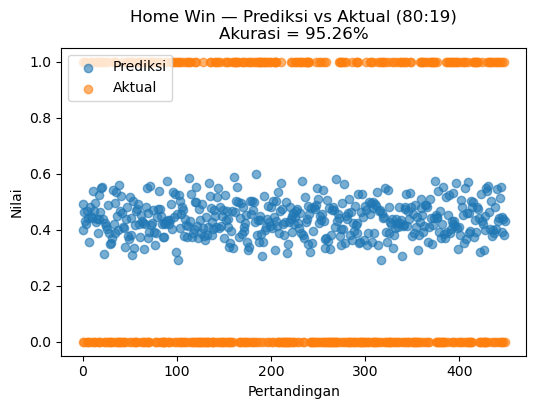

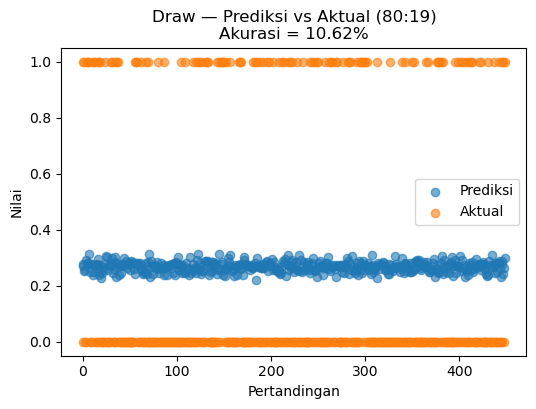

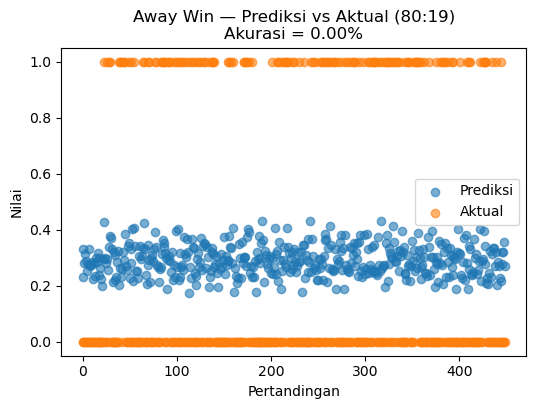

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, beta_full_H, beta_full_A, alpha]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



=== HASIL SPLIT 70:30 ===
Jumlah data TRAIN: 1575 | TEST: 675 | Dievaluasi: 675 | Dilewati (unseen team): 0
LogLoss : 1.0612
Brier   : 0.6386
Akurasi : 0.4444
Akurasi Home : 0.9461 | Away : 0.0000 | Draw : 0.1203
Disimpan: bhm_epl70.xlsx


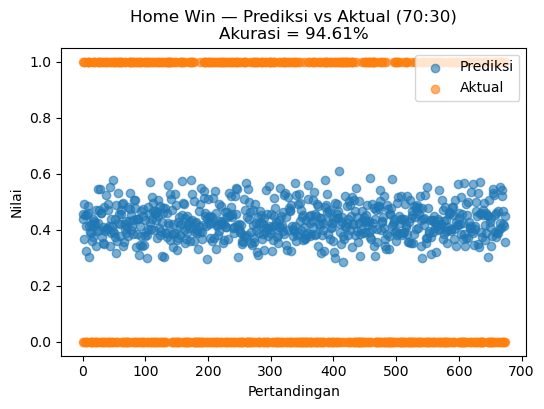

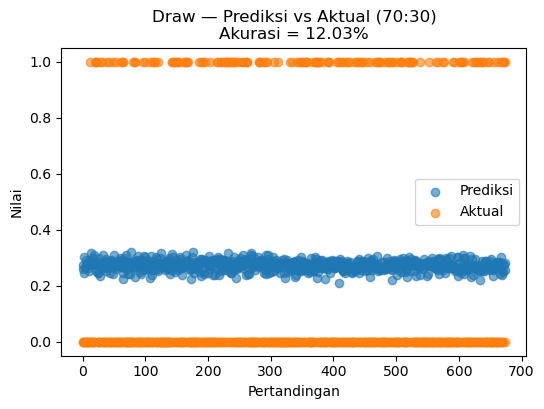

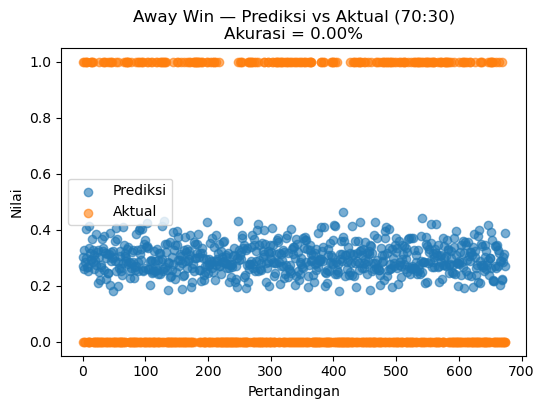

In [49]:
# =====================================================
# EVALUASI BHM EPL: 80:20 dan 70:30 (time-aware split)
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# Util metrik & plotting
# ------------------------
def log_loss_mc(y_true, proba, eps=1e-12):
    p = np.clip(proba, eps, 1-eps)
    return -np.mean(np.log(p[np.arange(len(y_true)), y_true]))

def brier_mc(y_true, proba):
    Y = np.eye(3)[y_true]
    return np.mean(np.sum((proba - Y)**2, axis=1))

def accuracy_total(y_true, proba):
    return np.mean(np.argmax(proba, axis=1) == y_true)

def accuracy_per_class(y_true, proba, cls):
    # cls: 0=Home,1=Away,2=Draw
    mask = (y_true == cls)
    if mask.sum() == 0:
        return 0.0
    pred = np.argmax(proba, axis=1)
    return np.mean(pred[mask] == y_true[mask])

def plot_prob_with_accuracy(pred, actual, title, acc_value):
    plt.figure(figsize=(6,4))
    plt.scatter(range(len(pred)), pred, label="Prediksi", alpha=0.6)
    plt.scatter(range(len(actual)), actual, label="Aktual", alpha=0.6)
    plt.title(f"{title}\nAkurasi = {acc_value*100:.2f}%")
    plt.xlabel("Pertandingan")
    plt.ylabel("Nilai")
    plt.legend()
    plt.show()

# ------------------------
# Encoder label hasil FT
# ------------------------
def encode_y_true_from_scores(df_):
    # 0=Home, 1=Away, 2=Draw
    y = np.where(df_["FTHG"].values > df_["FTAG"].values, 0,
        np.where(df_["FTHG"].values < df_["FTAG"].values, 1, 2))
    return y

# ------------------------
# Evaluasi untuk 1 split
# ------------------------
def train_and_evaluate_time_aware(df_all, train_ratio, excel_filename,
                                  likelihood="nb", draws=DRAWS, tune=TUNE, seed=123):
    """
    df_all : DataFrame lengkap (sudah siap: HomeID, AwayID, FTHG, FTAG, fitur2)
    train_ratio : 0.8 (80:20) atau 0.7 (70:30)
    excel_filename : nama file excel untuk simpan hasil test, mis. 'bhm_epl_80.xlsx'
    """
    n = len(df_all)
    n_train = int(np.floor(train_ratio * n))
    df_train = df_all.iloc[:n_train].copy()
    df_test  = df_all.iloc[n_train:].copy()

    # Build data untuk TRAIN (mapping id_to_idx berasal dari train)
    data_train = build_data(df_train)

    # Train BHM pada data TRAIN
    model = build_model(data_train, mode="full", likelihood=likelihood)
    trace = sample_model(model, draws=draws, tune=tune, target_accept=0.9, random_seed=seed)

    # Siapkan penampung hasil TEST
    rows = []
    skipped = 0

    # y_true dari skor aktual test
    y_true = encode_y_true_from_scores(df_test)

    # Prediksi probabilitas utk setiap baris test (yang timnya ada di train)
    for idx, row in df_test.reset_index(drop=True).iterrows():
        h = int(row["HomeID"]); a = int(row["AwayID"])
        # skip jika tim tak ada di mapping train
        if (h not in data_train["id_to_idx"]) or (a not in data_train["id_to_idx"]):
            skipped += 1
            continue

        pred = predict_probs_by_id(trace, data_train, h, a, likelihood=likelihood)
        rows.append({
            "idx": idx,
            "HomeID": h,
            "AwayID": a,
            "FTHG": row["FTHG"],
            "FTAG": row["FTAG"],
            "y_true": y_true[idx],          # 0/1/2
            "p_home": pred["p_home"],
            "p_draw": pred["p_draw"],
            "p_away": pred["p_away"],
        })

    if len(rows) == 0:
        raise RuntimeError("Tidak ada baris test yang bisa dievaluasi (semua unseen team).")

    df_out = pd.DataFrame(rows).reset_index(drop=True)

    # One-vs-all aktual biner untuk plotting
    df_out["y_home"] = (df_out["y_true"] == 0).astype(int)
    df_out["y_away"] = (df_out["y_true"] == 1).astype(int)
    df_out["y_draw"] = (df_out["y_true"] == 2).astype(int)

    # Array metrik
    proba = df_out[["p_home","p_draw","p_away"]].values
    y_true_eval = df_out["y_true"].values

    # Metrik
    LL = log_loss_mc(y_true_eval, proba)
    BS = brier_mc(y_true_eval, proba)
    ACC = accuracy_total(y_true_eval, proba)
    ACC_H = accuracy_per_class(y_true_eval, proba, 0)
    ACC_A = accuracy_per_class(y_true_eval, proba, 1)
    ACC_D = accuracy_per_class(y_true_eval, proba, 2)

    print(f"\n=== HASIL SPLIT {int(train_ratio*100)}:{int((1-train_ratio)*100)} ===")
    print(f"Jumlah data TRAIN: {len(df_train)} | TEST: {len(df_test)} | Dievaluasi: {len(df_out)} | Dilewati (unseen team): {skipped}")
    print(f"LogLoss : {LL:.4f}")
    print(f"Brier   : {BS:.4f}")
    print(f"Akurasi : {ACC:.4f}")
    print(f"Akurasi Home : {ACC_H:.4f} | Away : {ACC_A:.4f} | Draw : {ACC_D:.4f}")

    # Simpan ke Excel
    df_out.to_excel(excel_filename, index=False)
    print(f"Disimpan: {excel_filename}")

    # Grafik Prediksi vs Aktual per kategori
    plot_prob_with_accuracy(df_out["p_home"].values, df_out["y_home"].values,
                            f"Home Win — Prediksi vs Aktual ({int(train_ratio*100)}:{int((1-train_ratio)*100)})",
                            ACC_H)
    plot_prob_with_accuracy(df_out["p_draw"].values, df_out["y_draw"].values,
                            f"Draw — Prediksi vs Aktual ({int(train_ratio*100)}:{int((1-train_ratio)*100)})",
                            ACC_D)
    plot_prob_with_accuracy(df_out["p_away"].values, df_out["y_away"].values,
                            f"Away Win — Prediksi vs Aktual ({int(train_ratio*100)}:{int((1-train_ratio)*100)})",
                            ACC_A)

    # Kembalikan ringkasan metrik + dataframe hasil
    return {
        "logloss": LL,
        "brier": BS,
        "accuracy": ACC,
        "acc_home": ACC_H,
        "acc_away": ACC_A,
        "acc_draw": ACC_D,
        "evaluated_rows": len(df_out),
        "skipped_rows": skipped,
        "df_result": df_out,
        "trace": trace,
    }

# =====================================================
# JALANKAN: 80:20 -> bhm_epl_80.xlsx ; 70:30 -> bhm_epl70.xlsx
# =====================================================
res_8020 = train_and_evaluate_time_aware(
    df_all=df,
    train_ratio=0.80,
    excel_filename="bhm_epl_80.xlsx",
    likelihood=LIKELIHOOD,
    draws=DRAWS,
    tune=TUNE,
    seed=202
)

res_7030 = train_and_evaluate_time_aware(
    df_all=df,
    train_ratio=0.70,
    excel_filename="bhm_epl70.xlsx",
    likelihood=LIKELIHOOD,
    draws=DRAWS,
    tune=TUNE,
    seed=7030
)


In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# ==========================================================
# Fungsi prediksi BHM → p_home, p_draw, p_away
# ==========================================================
def predict_probs_by_id(trace, data, home_id, away_id, likelihood="nb"):
    att = trace.posterior["attack"].values
    dff = trace.posterior["defense"].values
    hadv = trace.posterior["home_adv"].values

    hidx = data["id_to_idx"][home_id]
    aidx = data["id_to_idx"][away_id]

    # linear predictor
    lin_home = hadv + att[:,:,hidx] - dff[:,:,aidx]
    lin_away =        att[:,:,aidx] - dff[:,:,hidx]

    muH = np.exp(lin_home)
    muA = np.exp(lin_away)

    # simulating scores
    lamH = muH.reshape(-1)
    lamA = muA.reshape(-1)

    alpha = float(trace.posterior["alpha"].mean())
    goalsH = np.random.negative_binomial(alpha, alpha/(alpha+lamH))
    goalsA = np.random.negative_binomial(alpha, alpha/(alpha+lamA))

    pH = np.mean(goalsH > goalsA)
    pD = np.mean(goalsH == goalsA)
    pA = np.mean(goalsH < goalsA)

    return pH, pD, pA

# ==========================================================
# Multiclass Brier score
# ==========================================================
def brier_multi(y_true, probs):
    y_true = np.array(y_true)
    probs = np.array(probs)

    y_onehot = np.zeros_like(probs)
    for i, c in enumerate(y_true):
        y_onehot[i, c] = 1

    return np.mean(np.sum((probs - y_onehot)**2, axis=1))


# ==========================================================
# Siapkan dataframe
# ==========================================================
df_eval = df.copy()

# Label hasil aktual
y_true = []
for h,a in zip(df_eval["FTHG"], df_eval["FTAG"]):
    if h > a: y_true.append(0)     # home menang
    elif h == a: y_true.append(1)  # draw
    else: y_true.append(2)         # away menang

df_eval["y_true"] = y_true

# ==========================================================
# Predict seluruh pertandingan (satu kali saja)
# ==========================================================
p_home = []
p_draw = []
p_away = []

for h, a in zip(df_eval["HomeID"], df_eval["AwayID"]):
    ph, pd, pa = predict_probs_by_id(trace_full, data_full, h, a)
    p_home.append(ph)
    p_draw.append(pd)
    p_away.append(pa)

df_eval["p_home"] = p_home
df_eval["p_draw"] = p_draw
df_eval["p_away"] = p_away

# Prediksi argmax
df_eval["y_pred"] = df_eval[["p_home","p_draw","p_away"]].idxmax(axis=1).map(
                       {"p_home":0,"p_draw":1,"p_away":2}
                   )

# ==========================================================
# === SPLIT 80:20 ===
# ==========================================================
train_8020, test_8020 = train_test_split(df_eval, test_size=0.20, shuffle=False)

pred_8020 = test_8020.copy()

logloss_8020 = log_loss(pred_8020["y_true"],
                        pred_8020[["p_home","p_draw","p_away"]])
brier_8020  = brier_multi(pred_8020["y_true"],
                          pred_8020[["p_home","p_draw","p_away"]])
acc_8020    = (pred_8020["y_true"] == pred_8020["y_pred"]).mean()

print("=== SPLIT 80:20 ===")
print("Jumlah data TRAIN:", len(train_8020), "| TEST:", len(test_8020))
print("LogLoss :", round(logloss_8020,4))
print("Brier   :", round(brier_8020,4))
print("Akurasi :", round(acc_8020,4))

# simpan excel
pred_8020[["HomeTeam","AwayTeam","p_home","p_draw","p_away","y_true","y_pred"]]\
        .to_excel("bhm_epl_8020.xlsx", index=False)

# ambil 10 data terakhir
print("\n--- 10 Data Terakhir (80:20) ---")
print(pred_8020.tail(10))


# ==========================================================
# === SPLIT 70:30 ===
# ==========================================================
train_7030, test_7030 = train_test_split(df_eval, test_size=0.30, shuffle=False)

pred_7030 = test_7030.copy()

logloss_7030 = log_loss(pred_7030["y_true"],
                        pred_7030[["p_home","p_draw","p_away"]])
brier_7030  = brier_multi(pred_7030["y_true"],
                          pred_7030[["p_home","p_draw","p_away"]])
acc_7030    = (pred_7030["y_true"] == pred_7030["y_pred"]).mean()

print("\n=== SPLIT 70:30 ===")
print("Jumlah data TRAIN:", len(train_7030), "| TEST:", len(test_7030))
print("LogLoss :", round(logloss_7030,4))
print("Brier   :", round(brier_7030,4))
print("Akurasi :", round(acc_7030,4))

# simpan excel
pred_7030[["HomeTeam","AwayTeam","p_home","p_draw","p_away","y_true","y_pred"]]\
        .to_excel("bhm_epl_7030.xlsx", index=False)

# ambil 10 data terakhir
print("\n--- 10 Data Terakhir (70:30) ---")
print(pred_7030.tail(10))


=== SPLIT 80:20 ===
Jumlah data TRAIN: 1800 | TEST: 450
LogLoss : 1.0343
Brier   : 0.6217
Akurasi : 0.4622

--- 10 Data Terakhir (80:20) ---
           Date        HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
2240 2025-05-02        Man City         Wolves     1     0   H     1     0   
2241 2025-05-03     Aston Villa         Fulham     1     0   H     1     0   
2242 2025-05-03         Everton        Ipswich     2     2   D     2     1   
2243 2025-05-03       Leicester    Southampton     2     0   H     2     0   
2244 2025-05-03         Arsenal    Bournemouth     1     2   A     1     0   
2245 2025-05-04       Brentford     Man United     4     3   H     2     1   
2246 2025-05-04        Brighton      Newcastle     1     1   D     1     0   
2247 2025-05-04        West Ham      Tottenham     1     1   D     1     1   
2248 2025-05-04         Chelsea      Liverpool     3     1   H     1     0   
2249 2025-05-05  Crystal Palace  Nott'M Forest     1     1   D     0     0   



Log Loss : 1.042023074910414
Brier    : 0.6253920668945312
Akurasi total : 0.445
Akurasi home  : 0.8735632183908046
Akurasi away  : 0.0
Akurasi draw  : 0.25


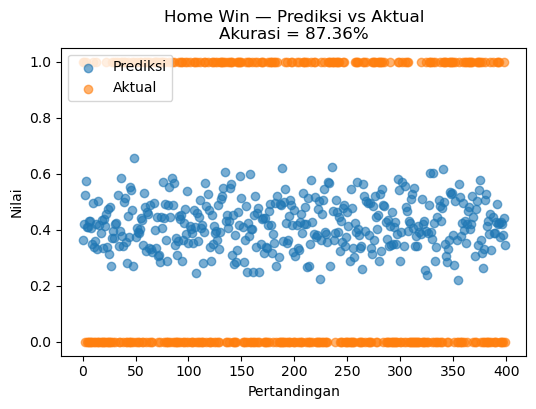

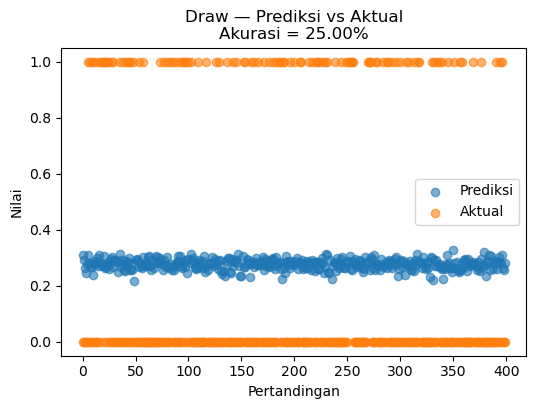

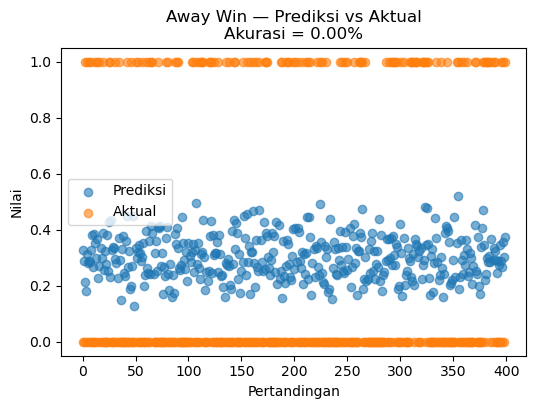

In [14]:
map_df = pd.DataFrame({"id": range(1, len(teams)+1), "name": teams})
# Tampilkan semua ID & Nama
print(map_df)


    id              name
0    1           Arsenal
1    2       Aston Villa
2    3       Bournemouth
3    4         Brentford
4    5          Brighton
5    6           Burnley
6    7           Chelsea
7    8    Crystal Palace
8    9           Everton
9   10            Fulham
10  11           Ipswich
11  12             Leeds
12  13         Leicester
13  14         Liverpool
14  15             Luton
15  16          Man City
16  17        Man United
17  18         Newcastle
18  19           Norwich
19  20     Nott'M Forest
20  21     Nott'm Forest
21  22  Sheffield United
22  23       Southampton
23  24         Tottenham
24  25           Watford
25  26         West Brom
26  27          West Ham
27  28            Wolves


In [7]:
# =============================================
# BHM + NB untuk EPL (Optimized)
# - Hierarchical attack/defense + home_adv
# - Negative Binomial dengan alpha terpisah (home/away)
# - Regularisasi L1 (Laplace) untuk koefisien fitur
# - Asymmetric features: H* -> home, A* -> away
# - Half-time blending yang "score-aware" & "gap-aware"
# =============================================

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import pickle
import pandas as pd



with open("bhm_nbr_model_2.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model disimpan:", model_data["info"]["trained_on"])


# =======================
# CONFIG
# =======================
LIKELIHOOD = "nb"   # "poisson" atau "nb"
USE_SCALING = True

# Fitur yang umumnya tersedia untuk EPL
FULL_FEATS  = ["HST","AST","HS","AS","HC","AC","HY","AY","HR","AR","hst","ast","hs","aws","hc","ac","hy","ay","hr","ar"]
HT_FEATS    = ["HTHG","HTAG","hthg","htag"]

# Sampling budget
DRAWS = 800
TUNE  = 800
TARGET_ACCEPT = 0.9
RANDOM_SEED = 42

# =======================
# 1) LOAD & PREPROCESS
# =======================
df = pd.read_excel("epl_matches_with_ids.xlsx", sheet_name=0)
df = df.drop(columns=[c for c in df.columns if str(c).startswith("Unnamed")], errors="ignore")

# Kolom ID tim
col_home_id = "HomeID" if "HomeID" in df.columns else ("home_id" if "home_id" in df.columns else None)
col_away_id = "AwayID" if "AwayID" in df.columns else ("away_id" if "away_id" in df.columns else None)
if col_home_id is None or col_away_id is None:
    raise ValueError("Dataset harus punya kolom HomeID/AwayID (atau home_id/away_id).")

df["HomeID"] = pd.to_numeric(df[col_home_id], errors="coerce").astype("Int64")
df["AwayID"] = pd.to_numeric(df[col_away_id], errors="coerce").astype("Int64")

# Nama tim (opsional, untuk debug/ekspor)
if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    df["HomeTeam"] = df["HomeTeam"].astype(str).str.strip()
    df["AwayTeam"] = df["AwayTeam"].astype(str).str.strip()

df = df.dropna(subset=["HomeID","AwayID"]).reset_index(drop=True)
df["HomeID"] = df["HomeID"].astype(int)
df["AwayID"] = df["AwayID"].astype(int)

# Kolom gol final
g_home_col = "FTHG" if "FTHG" in df.columns else ("fthg" if "fthg" in df.columns else None)
g_away_col = "FTAG" if "FTAG" in df.columns else ("ftag" if "ftag" in df.columns else None)
if g_home_col is None or g_away_col is None:
    raise ValueError("Dataset harus punya kolom FTHG/FTAG (atau fthg/ftag).")

df["FTHG"] = pd.to_numeric(df[g_home_col], errors="coerce")
df["FTAG"] = pd.to_numeric(df[g_away_col], errors="coerce")
df = df.loc[df["FTHG"].notna() & df["FTAG"].notna()].copy()

# Alias fitur (lower->upper)
_alias = {
    "hst":"HST","ast":"AST","hs":"HS","aws":"AS","hc":"HC","ac":"AC",
    "hy":"HY","ay":"AY","hr":"HR","ar":"AR",
    "hthg":"HTHG","htag":"HTAG"
}
for low, up in _alias.items():
    if low in df.columns and up not in df.columns:
        df[up] = pd.to_numeric(df[low], errors="coerce").fillna(0)

for up in set(_alias.values()):
    if up in df.columns:
        df[up] = pd.to_numeric(df[up], errors="coerce").fillna(0)

# Pastikan numeric dan isi nol bila kosong
for c in set([c.upper() for c in FULL_FEATS] + [c.upper() for c in HT_FEATS]):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Scaling fitur agar stabil (temo tinggi EPL -> skala variabel bervariasi)
if USE_SCALING:
    from sklearn.preprocessing import StandardScaler
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df.columns]
    if H_cols:
        df[H_cols] = StandardScaler().fit_transform(df[H_cols])
    if A_cols:
        df[A_cols] = StandardScaler().fit_transform(df[A_cols])

# =======================
# 2) DATA BUILDERS
# =======================
unique_ids = np.unique(np.concatenate([df["HomeID"].values, df["AwayID"].values]))
unique_ids = np.sort(unique_ids)
id_to_idx = {tid: i for i, tid in enumerate(unique_ids)}
idx_to_id = {i: tid for tid, i in id_to_idx.items()}

# Peta nama tim (opsional)
id_to_name = None
if "HomeTeam" in df.columns and "AwayTeam" in df.columns:
    name_map = {}
    for _, r in df[["HomeID","HomeTeam"]].dropna().iterrows():
        name_map[int(r["HomeID"])] = str(r["HomeTeam"])
    for _, r in df[["AwayID","AwayTeam"]].dropna().iterrows():
        name_map.setdefault(int(r["AwayID"]), str(r["AwayTeam"]))
    id_to_name = {tid: name_map.get(tid, f"Team_{tid}") for tid in unique_ids}

def split_feats_available(df_):
    # Asimetri: H* hanya untuk model home, A* hanya untuk model away
    H_cols = [c for c in ["HST","HS","HC","HY","HR"] if c in df_.columns]
    A_cols = [c for c in ["AST","AS","AC","AY","AR"] if c in df_.columns]
    return H_cols, A_cols

def build_data(df_):
    H_full, A_full = split_feats_available(df_)
    return {
        "team_ids": unique_ids,
        "id_to_idx": id_to_idx,
        "idx_to_id": idx_to_id,
        "id_to_name": id_to_name,
        "home_idx": df_["HomeID"].map(id_to_idx).values.astype("int32"),
        "away_idx": df_["AwayID"].map(id_to_idx).values.astype("int32"),
        "goals_home": df_["FTHG"].values.astype("int32"),
        "goals_away": df_["FTAG"].values.astype("int32"),
        "H_full": H_full, "A_full": A_full,
        "XH_full": df_[H_full].values.astype("float32") if H_full else None,
        "XA_full": df_[A_full].values.astype("float32") if A_full else None,
        "HTHG": df_["HTHG"].values.astype("float32") if "HTHG" in df_.columns else None,
        "HTAG": df_["HTAG"].values.astype("float32") if "HTAG" in df_.columns else None,
    }

data_full = build_data(df)

# =======================
# 3) BUILD MODEL (Hierarchical NB + L1 on features)
# =======================
def build_model(data, likelihood=LIKELIHOOD):
    n_teams = len(data["team_ids"])
    H_dim = len(data["H_full"])
    A_dim = len(data["A_full"])

    coords = {"team": np.arange(n_teams)}
    if H_dim > 0: coords["feat_H"] = np.arange(H_dim)
    if A_dim > 0: coords["feat_A"] = np.arange(A_dim)
    coords["match"] = np.arange(len(data["home_idx"]))

    with pm.Model(coords=coords) as model:
        # Priors untuk deviasi attack/defense per tim (ketat EPL -> varians moderat)
        sigma_att = pm.Exponential("sigma_att", 1.0)
        sigma_def = pm.Exponential("sigma_def", 1.0)

        attack_raw  = pm.Normal("attack_raw", 0, sigma_att, dims="team")
        defense_raw = pm.Normal("defense_raw", 0, sigma_def, dims="team")

        # Pusatkan di mean zero
        attack  = pm.Deterministic("attack",  attack_raw  - pt.mean(attack_raw))
        defense = pm.Deterministic("defense", defense_raw - pt.mean(defense_raw))

        # Home advantage: EPL kuat, tapi tidak ekstrem
        home_adv = pm.Normal("home_adv", mu=0.12, sigma=0.10)

        # Linear predictor dasar
        lin_home = home_adv + attack[data["home_idx"]] - defense[data["away_idx"]]
        lin_away =            attack[data["away_idx"]] - defense[data["home_idx"]]

        # Koefisien fitur (asimetri) + regularisasi L1 (Laplace)
        if data["XH_full"] is not None and H_dim > 0:
            # Laplace(0, b) -> shrinkage L1
            betaH = pm.Laplace("betaH", mu=0.0, b=0.5, dims="feat_H")
            lin_home = lin_home + pt.dot(data["XH_full"], betaH)

        if data["XA_full"] is not None and A_dim > 0:
            betaA = pm.Laplace("betaA", mu=0.0, b=0.5, dims="feat_A")
            lin_away = lin_away + pt.dot(data["XA_full"], betaA)

        # Link
        mu_home = pm.Deterministic("mu_home", pt.exp(lin_home))
        mu_away = pm.Deterministic("mu_away", pt.exp(lin_away))

        # Likelihood
        if likelihood == "poisson":
            pm.Poisson("y_home", mu=mu_home, observed=data["goals_home"])
            pm.Poisson("y_away", mu=mu_away, observed=data["goals_away"])
        else:
            # Alpha terpisah untuk home/away (fleksibel menghadapi varians EPL)
            alpha_home = pm.Exponential("alpha_home", 2.0)
            alpha_away = pm.Exponential("alpha_away", 2.0)
            pm.NegativeBinomial("y_home", mu=mu_home, alpha=alpha_home, observed=data["goals_home"])
            pm.NegativeBinomial("y_away", mu=mu_away, alpha=alpha_away, observed=data["goals_away"])

    return model

def sample_model(model, draws=DRAWS, tune=TUNE, target_accept=TARGET_ACCEPT, random_seed=RANDOM_SEED):
    with model:
        return pm.sample(draws=draws, tune=tune, target_accept=target_accept, random_seed=random_seed)

# =======================
# 4) TRAIN
# =======================
print("Training BHM (NB, L1-regularized features)...")
model_full = build_model(data_full, likelihood=LIKELIHOOD)
trace_full = sample_model(model_full)
if LIKELIHOOD.startswith("nb"):
    print("alpha_home mean =", float(trace_full.posterior["alpha_home"].mean()))
    print("alpha_away mean =", float(trace_full.posterior["alpha_away"].mean()))

# =======================
# 5) PREDICTORS
# =======================
def predict_probs_by_id(trace, data, home_id, away_id, likelihood=LIKELIHOOD):
    """
    Hitung probabilitas H/D/A dari posterior + mean mu_home/mu_away.
    """
    att = trace.posterior["attack"].values      # (chain, draw, team)
    dff = trace.posterior["defense"].values
    hadv = trace.posterior["home_adv"].values   # (chain, draw)

    hidx = data["id_to_idx"][home_id]
    aidx = data["id_to_idx"][away_id]

    # log intensitas
    lin_home = hadv + att[:,:,hidx] - dff[:,:,aidx]
    lin_away =        att[:,:,aidx] - dff[:,:,hidx]

    muH = np.exp(lin_home)
    muA = np.exp(lin_away)

    mu_home_mean = float(muH.mean())
    mu_away_mean = float(muA.mean())

    lamH = muH.reshape(-1)
    lamA = muA.reshape(-1)

    if likelihood == "nb" or likelihood == "negative_binomial":
        aH = float(trace.posterior["alpha_home"].mean())
        aA = float(trace.posterior["alpha_away"].mean())
        # NB sampling (parameterisasi: mean=mu, alpha=shape)
        # success prob p = alpha/(alpha+mu)
        goalsH = np.random.negative_binomial(aH, aH/(aH + lamH))
        goalsA = np.random.negative_binomial(aA, aA/(aA + lamA))
    else:
        goalsH = np.random.poisson(lamH)
        goalsA = np.random.poisson(lamA)

    winH = np.mean(goalsH > goalsA)
    draw = np.mean(goalsH == goalsA)
    winA = np.mean(goalsH < goalsA)

    s = winH + draw + winA + 1e-12
    return {
        "home_id": home_id,
        "away_id": away_id,
        "p_home": float(winH/s),
        "p_draw": float(draw/s),
        "p_away": float(winA/s),
        "mu_home_mean": mu_home_mean,
        "mu_away_mean": mu_away_mean,
    }

# =======================
# 6) TEAM STRENGTH (xG-like proxy dari SOT)
# =======================
def build_team_strength_from_shots(df):
    """
    Estimasi sederhana "rating" berbasis shots on target (HST/AST)
    sebagai proxy xG (bila xG tidak tersedia). Regularized ridge kecil.
    """
    if "HST" not in df or "AST" not in df:
        raise ValueError("Butuh kolom HST dan AST.")
    hids, aids = df["HomeID"], df["AwayID"]
    teams = np.unique(np.concatenate([hids, aids]))
    n = len(teams)
    id2idx = {tid: i for i, tid in enumerate(teams)}
    m = len(df)*2
    p = 2 + 2*n
    X = np.zeros((m, p), dtype=float)
    y = np.zeros(m, dtype=float)
    r = 0
    for _, row in df.iterrows():
        hi = id2idx[row["HomeID"]]; ai = id2idx[row["AwayID"]]
        xgh = float(row["HST"]); xga = float(row["AST"])
        # home eq
        X[r, [0, 1, 2+hi, 2+n+ai]] = [1, 1, 1, -1];  y[r] = xgh; r += 1
        # away eq
        X[r, [0, 2+ai, 2+n+hi]]     = [1, 1, -1];    y[r] = xga; r += 1
    lam = 1e-3
    A = X.T @ X + lam*np.eye(p)
    b = X.T @ y
    coef = np.linalg.solve(A, b)
    att = coef[2:2+n]
    dff = coef[2+n:]
    idx2id = {i: t for t, i in id2idx.items()}
    # rating = attack - defense
    ratings = {idx2id[i]: float(att[i] - dff[i]) for i in range(n)}
    return ratings

def quality_gap_and_tier(ratings, home_id, away_id):
    gap = ratings.get(home_id, 0.0) - ratings.get(away_id, 0.0)
    vals = np.array(list(ratings.values()))
    if len(vals) == 0:
        return 0.0, 0.0, "balanced"
    med = np.median(vals)
    mad = np.median(np.abs(vals - med)) + 1e-9
    gap_scaled = gap / (1.4826 * mad)
    g = abs(gap_scaled)
    if g >= 1.2: tier = "big_vs_small"
    elif g >= 0.6: tier = "big_vs_mid"
    elif g >= 0.25: tier = "mid_vs_small"
    else: tier = "balanced"
    return float(gap), float(gap_scaled), tier

# =======================
# 7) HALF-TIME PREDICTOR (score-aware & gap-aware)
# =======================
def predict_by_id_ht(trace, data, home_id, away_id, hthg, htag, likelihood=LIKELIHOOD):
    """
    Menggabungkan pre-match posterior (BHM) dengan informasi skor HT.
    Gagasan:
      - Pre-match: gunakan E[mu]_posterior untuk intensitas gol per tim.
      - Second-half expected goals: skala dari pre-match intensitas,
        lalu tambahkan efek keunggulan skor (momentum) ringan.
      - Probabilitas H/D/A dihitung dari simulasi skor final
        (H_goals = HTHG + goals_2nd_half, dll).
      - Bobot "w_live" ditentukan oleh gap kualitas & selisih skor HT.
    """
    pre = predict_probs_by_id(trace, data, home_id, away_id, likelihood=likelihood)
    muH_pre = pre["mu_home_mean"]
    muA_pre = pre["mu_away_mean"]

    # Rating dari shots-on-target sebagai proxy xG
    ratings = build_team_strength_from_shots(df)
    gap_raw, gap_scaled, tier = quality_gap_and_tier(ratings, home_id, away_id)

    # Bobot live: makin imbang kualitas (gap kecil) & makin besar selisih skor HT, makin besar w_live
    lead = abs(hthg - htag)
    w_live_base = np.clip(1.0 - np.tanh(0.6 * abs(gap_scaled)), 0.1, 0.9)
    w_live = np.clip(w_live_base + 0.15 * lead, 0.1, 0.95)
    w_pre = 1.0 - w_live

    # Perkiraan intensitas babak kedua:
    # Ambil ~45% dari pre-match mean untuk second-half, lalu modifikasi oleh skor HT
    # Jika unggul, tim cenderung lebih konservatif; jika tertinggal, lebih agresif.
    scale_2nd = 0.45
    adjH = 1.0 + 0.12 * (htag - hthg)  # jika Home tertinggal (HTAG>HTHG), agresif -> muH naik
    adjA = 1.0 + 0.12 * (hthg - htag)  # jika Away tertinggal, muA naik
    muH_2nd = np.clip(scale_2nd * muH_pre * adjH, 1e-6, None)
    muA_2nd = np.clip(scale_2nd * muA_pre * adjA, 1e-6, None)

    # Blending dengan bobot live vs pre
    # Untuk probabilitas hasil, kita campur p(H/D/A) pre-match dengan "hasil simulasi HT-informed"
    # Simulasi babak kedua (NB atau Poisson) lalu tambah skor HT, ukur final outcome
    n = 80_000  # cukup besar agar stabil
    if likelihood == "nb" or likelihood == "negative_binomial":
        aH = float(trace.posterior["alpha_home"].mean())
        aA = float(trace.posterior["alpha_away"].mean())
        g2H = np.random.negative_binomial(aH, aH/(aH + muH_2nd), size=n)
        g2A = np.random.negative_binomial(aA, aA/(aA + muA_2nd), size=n)
    else:
        g2H = np.random.poisson(muH_2nd, size=n)
        g2A = np.random.poisson(muA_2nd, size=n)

    finals_H = hthg + g2H
    finals_A = htag + g2A

    winH_live = np.mean(finals_H > finals_A)
    draw_live = np.mean(finals_H == finals_A)
    winA_live = np.mean(finals_H < finals_A)

    pH = w_pre * pre["p_home"] + w_live * winH_live
    pD = w_pre * pre["p_draw"] + w_live * draw_live
    pA = w_pre * pre["p_away"] + w_live * winA_live
    s = pH + pD + pA + 1e-12
    pH, pD, pA = pH/s, pD/s, pA/s

    # Estimasi mean gol final (gabung ekspektasi pre + live yang mempertimbangkan skor)
    muH_final = w_pre * pre["mu_home_mean"] + w_live * (muH_pre + hthg)
    muA_final = w_pre * pre["mu_away_mean"] + w_live * (muA_pre + htag)

    return {
        "home_id": home_id,
        "away_id": away_id,
        "p_home": float(pH),
        "p_draw": float(pD),
        "p_away": float(pA),
        "mu_home_mean": float(muH_final),
        "mu_away_mean": float(muA_final),
        "gap_rating": float(gap_raw),
        "gap_scaled": float(gap_scaled),
        "tier": tier,
        "w_live": float(w_live),
        "w_pre": float(w_pre),
    }

# =======================
# 8) EVALUASI SINGKAT (opsional)
# =======================
def evaluate_hda_argmax(prob_triplets, true_outcomes):
    """
    prob_triplets: list of dict {'p_home','p_draw','p_away'}
    true_outcomes: array like with values in { 'H','D','A' } berdasarkan hasil FTHG vs FTAG
    Mengembalikan akurasi argmax.
    """
    pred = []
    for p in prob_triplets:
        v = np.array([p["p_home"], p["p_draw"], p["p_away"]])
        i = int(np.argmax(v))
        pred.append(["H","D","A"][i])
    pred = np.array(pred)
    true = np.array(true_outcomes)
    return float(np.mean(pred == true))

def compute_logloss_brier(prob_triplets, true_outcomes):
    """
    Logloss & Brier untuk multi-class {H,D,A}.
    """
    mapping = {"H":0,"D":1,"A":2}
    y = np.array([mapping[t] for t in true_outcomes])
    P = np.array([[p["p_home"], p["p_draw"], p["p_away"]] for p in prob_triplets], dtype=float)
    eps = 1e-15
    P = np.clip(P, eps, 1-eps)
    # Logloss
    ll = -np.mean(np.log(P[np.arange(len(y)), y]))
    # Brier
    Y = np.eye(3)[y]
    br = np.mean(np.sum((P - Y)**2, axis=1))
    return float(ll), float(br)

# =======================
# 9) CONTOH PEMAKAIAN
# =======================
print("\n=== TEST: PRE-MATCH ===")
print(predict_probs_by_id(trace_full, data_full, home_id=data_full["idx_to_id"][0], away_id=data_full["idx_to_id"][15], likelihood=LIKELIHOOD))

print("\n=== TEST: HALF-TIME ===")
res_ht = predict_by_id_ht(trace_full, data_full,
                          home_id=data_full["idx_to_id"][0],
                          away_id=data_full["idx_to_id"][5],
                          hthg=1, htag=1,
                          likelihood=LIKELIHOOD)
print(res_ht)


Model disimpan: 2025-10-30 00:04:40.915943
Training BHM (NB, L1-regularized features)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_att, sigma_def, attack_raw, defense_raw, home_adv, betaH, betaA, alpha_home, alpha_away]


Output()

Sampling 4 chains for 800 tune and 800 draw iterations (3_200 + 3_200 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


alpha_home mean = 16.685442585341562
alpha_away mean = 14.479643793579783

=== TEST: PRE-MATCH ===
{'home_id': np.int64(1), 'away_id': np.int64(16), 'p_home': 0.45312499999954686, 'p_draw': 0.24343749999975653, 'p_away': 0.30343749999969655, 'mu_home_mean': 1.5770583872721182, 'mu_away_mean': 1.2332655158996289}

=== TEST: HALF-TIME ===
{'home_id': np.int64(1), 'away_id': np.int64(6), 'p_home': 0.4507314102349595, 'p_draw': 0.37656022058932276, 'p_away': 0.17270836917471763, 'mu_home_mean': 2.441775887371159, 'mu_away_mean': 1.589173893351489, 'gap_rating': -0.10538884678615418, 'gap_scaled': -0.41591480175965856, 'tier': 'mid_vs_small', 'w_live': 0.7555054429319681, 'w_pre': 0.24449455706803191}


In [6]:
import pickle
import pandas as pd

model_data = {
    "trace_full": trace_full,
    "data": data_full,
    "df": df,
    "info": {
        "trained_on": str(pd.Timestamp.now()),
        "note": "BHM EPL NB + HT blending",
    }
}

with open("bhm_epl.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model EPL disimpan:", model_data["info"]["trained_on"])


Model EPL disimpan: 2025-10-30 00:04:40.915943


In [3]:
# =========================================================
# EVALUASI PROBABILITAS H/D/A DENGAN DIXON–COLES
# =========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from math import factorial, exp

# =========================================================
# 1) BACA MU POSTERIOR
# =========================================================
mu_home_post = trace_full.posterior["mu_home"].mean(dim=("chain","draw")).values
mu_away_post = trace_full.posterior["mu_away"].mean(dim=("chain","draw")).values

mu_home_post = np.asarray(mu_home_post, dtype=float)
mu_away_post = np.asarray(mu_away_post, dtype=float)

# =========================================================
# 2) LABEL BENAR (H/D/A)
# =========================================================
def make_labels(gh, ga):
    lab = []
    for h,a in zip(gh,ga):
        if h > a: lab.append("H")
        elif h < a: lab.append("A")
        else: lab.append("D")
    return np.array(lab)

y_true = make_labels(data_full["goals_home"], data_full["goals_away"])
labels = np.array(["H","D","A"])
y_int = np.array([np.where(labels == k)[0][0] for k in y_true])

# =========================================================
# 3) DIXON–COLES
# =========================================================
def pois_pmf(k, lam):
    if lam <= 0:
        return 1.0 if k == 0 else 0.0
    return exp(-lam) * (lam**k) / factorial(k)

def dc_tau(yh, ya, muH, muA, rho):
    if yh == 0 and ya == 0:
        return max(1.0 - rho * muH * muA, 0.0)
    if yh == 0 and ya == 1:
        return max(1.0 + rho * muH, 0.0)
    if yh == 1 and ya == 0:
        return max(1.0 + rho * muA, 0.0)
    if yh == 1 and ya == 1:
        return max(1.0 - rho, 0.0)
    return 1.0

def dc_match_loglik(yh, ya, muH, muA, rho):
    return (np.log(pois_pmf(yh, muH) + 1e-18) +
            np.log(pois_pmf(ya, muA) + 1e-18) +
            np.log(dc_tau(yh, ya, muH, muA, rho) + 1e-18))

def fit_rho_dc(muH_all, muA_all, yH, yA, grid=np.linspace(-0.2,0.2,81)):
    best_rho = 0
    best_ll  = -1e99
    for r in grid:
        ll = 0.0
        for mh,ma,gh,ga in zip(muH_all,muA_all,yH,yA):
            ll += dc_match_loglik(int(gh), int(ga), float(mh), float(ma), r)
        if ll > best_ll:
            best_ll  = ll
            best_rho = r
    return best_rho

def dc_outcome_probs(muH, muA, rho, max_goal=10):
    pH = pD = pA = 0.0
    for gh in range(max_goal+1):
        pgh = pois_pmf(gh, muH)
        for ga in range(max_goal+1):
            pga = pois_pmf(ga, muA)
            w = dc_tau(gh, ga, muH, muA, rho)
            p = pgh * pga * w
            if gh > ga:
                pH += p
            elif gh == ga:
                pD += p
            else:
                pA += p
    s = pH + pD + pA + 1e-18
    return pH/s, pD/s, pA/s

print("Fitting rho (Dixon–Coles)…")
rho_hat = fit_rho_dc(
    mu_home_post, mu_away_post,
    data_full["goals_home"], data_full["goals_away"]
)
print("rho_hat =", rho_hat)

# =========================================================
# 4) HITUNG PROBABILITAS H/D/A
# =========================================================
probs_dc = np.zeros((len(mu_home_post),3), dtype=float)
for i,(mh,ma) in enumerate(zip(mu_home_post,mu_away_post)):
    probs_dc[i] = dc_outcome_probs(float(mh), float(ma), rho_hat)

# =========================================================
# 5) EVALUASI
# =========================================================

# 5a) Accuracy (argmax)
y_pred = labels[np.argmax(probs_dc, axis=1)]
acc = accuracy_score(y_true, y_pred)

# 5b) LogLoss
ll = log_loss(y_int, probs_dc)

# 5c) Brier Score
O = np.eye(3)[y_int]               # one-hot
bs = np.mean(np.sum((probs_dc - O)**2, axis=1))
print("Jumlah pertandingan evaluasi =", len(y_true))
print("Jumlah pertandingan total dataset =", len(df))

print("\n=== Evaluasi — Dixon–Coles ===")
print("Akurasi   :", acc)
print("LogLoss   :", ll)
print("Brier     :", bs)


Fitting rho (Dixon–Coles)…
rho_hat = -0.065
Jumlah pertandingan evaluasi = 2280
Jumlah pertandingan total dataset = 2280

=== Evaluasi — Dixon–Coles ===
Akurasi   : 0.6140350877192983
LogLoss   : 0.8682623640498534
Brier     : 0.5115906421990528


Akurasi total: 0.6140350877192983
Akurasi Home : 0.8344827586206897
Akurasi Draw : 0.1779935275080906
Akurasi Away : 0.6846986089644513


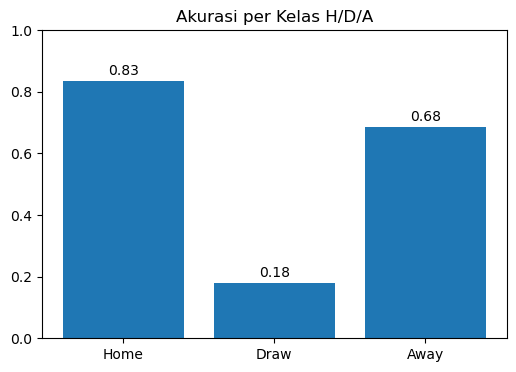

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ---------------------------------------
# asumsi:
#   probs_dc : array Nx3   → prob(H), prob(D), prob(A)
#   y_true   : array str   → ["H","A","D", ...]
# ---------------------------------------

labels = np.array(["H","D","A"])

# argmax → prediksi kelas
y_pred = labels[np.argmax(probs_dc, axis=1)]

# total accuracy
total_acc = accuracy_score(y_true, y_pred)
print("Akurasi total:", total_acc)

# ---------------------------------------
# hitung akurasi per kelas
# ---------------------------------------
def class_accuracy(y_true, y_pred, kelas):
    mask = (y_true == kelas)
    if mask.sum() == 0:
        return np.nan
    return accuracy_score(y_true[mask], y_pred[mask])

acc_home = class_accuracy(y_true, y_pred, "H")
acc_draw = class_accuracy(y_true, y_pred, "D")
acc_away = class_accuracy(y_true, y_pred, "A")

print("Akurasi Home :", acc_home)
print("Akurasi Draw :", acc_draw)
print("Akurasi Away :", acc_away)

# ---------------------------------------
# Plot akurasi per kelas
# ---------------------------------------
kelas   = ["Home", "Draw", "Away"]
nilai   = [acc_home, acc_draw, acc_away]

plt.figure(figsize=(6,4))
plt.bar(kelas, nilai)
plt.ylim(0,1)
plt.title("Akurasi per Kelas H/D/A")

for i, v in enumerate(nilai):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


Jumlah aktual  (H, D, A): [np.int64(1015), np.int64(618), np.int64(647)]
Jumlah prediksi (H, D, A): [np.int64(1311), np.int64(217), np.int64(752)]


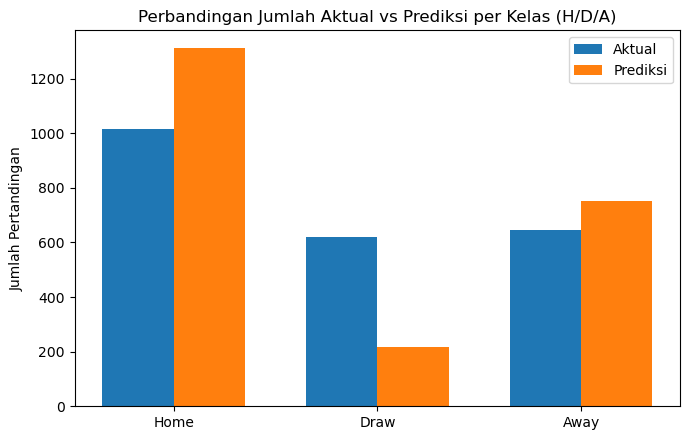

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Asumsi:
#  y_true  → array of "H","D","A"
#  probs_dc → Nx3 probabilitas hasil DC: [pH, pD, pA]
# =========================================================

labels = np.array(["H","D","A"])

# Prediksi kelas via argmax
y_pred = labels[np.argmax(probs_dc, axis=1)]

# Hitung jumlah aktual & prediksi
actual_counts = [np.sum(y_true == lab) for lab in labels]
pred_counts   = [np.sum(y_pred == lab) for lab in labels]

# Tampilkan angka
print("Jumlah aktual  (H, D, A):", actual_counts)
print("Jumlah prediksi (H, D, A):", pred_counts)

# =========================================================
# Plot
# =========================================================
x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(7,4.5))
plt.bar(x - w/2, actual_counts, width=w, label="Aktual")
plt.bar(x + w/2, pred_counts,   width=w, label="Prediksi")

plt.xticks(x, ["Home","Draw","Away"])
plt.ylabel("Jumlah Pertandingan")
plt.title("Perbandingan Jumlah Aktual vs Prediksi per Kelas (H/D/A)")
plt.legend()
plt.tight_layout()
plt.show()


Akurasi total: 0.6140350877192983

Jumlah Aktual per Kelas : {'H': np.int64(1015), 'D': np.int64(618), 'A': np.int64(647)}
Jumlah Prediksi Benar    : {'H': np.int64(847), 'D': np.int64(110), 'A': np.int64(443)}


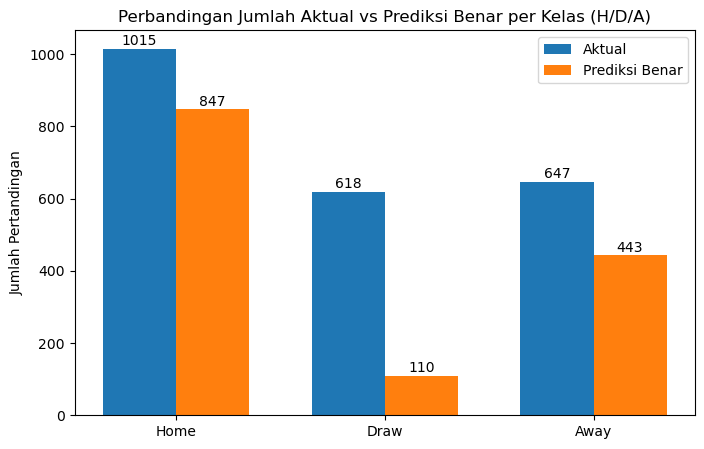

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

labels = np.array(["H","D","A"])

# prediksi kelas dari argmax
y_pred = labels[np.argmax(probs_dc, axis=1)]

# total accuracy
total_acc = accuracy_score(y_true, y_pred)
print("Akurasi total:", total_acc)


# ============================
# HITUNG JUMLAH PER KELAS
# ============================
daftar_kelas = ["H", "D", "A"]

# jumlah aktual (berapa match berlabel H/D/A)
aktual_count = {k: np.sum(y_true == k) for k in daftar_kelas}

# jumlah prediksi benar (true positives per kelas)
benar_count = {k: np.sum((y_true == k) & (y_pred == k)) for k in daftar_kelas}

print("\nJumlah Aktual per Kelas :", aktual_count)
print("Jumlah Prediksi Benar    :", benar_count)


# ============================
# VISUALISASI
# ============================
kelas = ["Home", "Draw", "Away"]
aktual = [aktual_count["H"], aktual_count["D"], aktual_count["A"]]
benar  = [benar_count["H"], benar_count["D"], benar_count["A"]]

x = np.arange(len(kelas))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, aktual, width, label="Aktual", color="tab:blue")
plt.bar(x + width/2, benar,  width, label="Prediksi Benar", color="tab:orange")

plt.xticks(x, kelas)
plt.ylabel("Jumlah Pertandingan")
plt.title("Perbandingan Jumlah Aktual vs Prediksi Benar per Kelas (H/D/A)")
plt.legend()

# tampilkan nilai di atas batang
for i, v in enumerate(aktual):
    plt.text(i - width/2, v + 10, str(v), ha='center')

for i, v in enumerate(benar):
    plt.text(i + width/2, v + 10, str(v), ha='center')

plt.show()


In [4]:
# =========================================================
# EVALUASI PROBABILITAS H/D/A DENGAN DIXON–COLES
# =========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from math import factorial, exp

# =========================================================
# 1) BACA MU POSTERIOR
# =========================================================
mu_home_post = trace_full.posterior["mu_home"].mean(dim=("chain","draw")).values
mu_away_post = trace_full.posterior["mu_away"].mean(dim=("chain","draw")).values

mu_home_post = np.asarray(mu_home_post, dtype=float)
mu_away_post = np.asarray(mu_away_post, dtype=float)

# =========================================================
# 2) LABEL BENAR (H/D/A)
# =========================================================
def make_labels(gh, ga):
    lab = []
    for h,a in zip(gh,ga):
        if h > a: lab.append("H")
        elif h < a: lab.append("A")
        else: lab.append("D")
    return np.array(lab)

y_true = make_labels(data_full["goals_home"], data_full["goals_away"])
labels = np.array(["H","D","A"])
y_int = np.array([np.where(labels == k)[0][0] for k in y_true])

# =========================================================
# 3) DIXON–COLES
# =========================================================
def pois_pmf(k, lam):
    if lam <= 0:
        return 1.0 if k == 0 else 0.0
    return exp(-lam) * (lam**k) / factorial(k)

def dc_tau(yh, ya, muH, muA, rho):
    if yh == 0 and ya == 0:
        return max(1.0 - rho * muH * muA, 0.0)
    if yh == 0 and ya == 1:
        return max(1.0 + rho * muH, 0.0)
    if yh == 1 and ya == 0:
        return max(1.0 + rho * muA, 0.0)
    if yh == 1 and ya == 1:
        return max(1.0 - rho, 0.0)
    return 1.0

def dc_match_loglik(yh, ya, muH, muA, rho):
    return (np.log(pois_pmf(yh, muH) + 1e-18) +
            np.log(pois_pmf(ya, muA) + 1e-18) +
            np.log(dc_tau(yh, ya, muH, muA, rho) + 1e-18))

def fit_rho_dc(muH_all, muA_all, yH, yA, grid=np.linspace(-0.2,0.2,81)):
    best_rho = 0
    best_ll  = -1e99
    for r in grid:
        ll = 0.0
        for mh,ma,gh,ga in zip(muH_all,muA_all,yH,yA):
            ll += dc_match_loglik(int(gh), int(ga), float(mh), float(ma), r)
        if ll > best_ll:
            best_ll  = ll
            best_rho = r
    return best_rho

def dc_outcome_probs(muH, muA, rho, max_goal=10):
    pH = pD = pA = 0.0
    for gh in range(max_goal+1):
        pgh = pois_pmf(gh, muH)
        for ga in range(max_goal+1):
            pga = pois_pmf(ga, muA)
            w = dc_tau(gh, ga, muH, muA, rho)
            p = pgh * pga * w
            if gh > ga:
                pH += p
            elif gh == ga:
                pD += p
            else:
                pA += p
    s = pH + pD + pA + 1e-18
    return pH/s, pD/s, pA/s

print("Fitting rho (Dixon–Coles)…")
rho_hat = fit_rho_dc(
    mu_home_post, mu_away_post,
    data_full["goals_home"], data_full["goals_away"]
)
print("rho_hat =", rho_hat)

# =========================================================
# 4) HITUNG PROBABILITAS H/D/A
# =========================================================
probs_dc = np.zeros((len(mu_home_post),3), dtype=float)
for i,(mh,ma) in enumerate(zip(mu_home_post,mu_away_post)):
    probs_dc[i] = dc_outcome_probs(float(mh), float(ma), rho_hat)

# =========================================================
# 5) EVALUASI
# =========================================================

# 5a) Accuracy (argmax)
y_pred = labels[np.argmax(probs_dc, axis=1)]
acc = accuracy_score(y_true, y_pred)

# 5b) LogLoss
ll = log_loss(y_int, probs_dc)

# 5c) Brier Score
O = np.eye(3)[y_int]               # one-hot
bs = np.mean(np.sum((probs_dc - O)**2, axis=1))

print("\n=== Evaluasi — Dixon–Coles ===")
print("Akurasi   :", acc)
print("LogLoss   :", ll)
print("Brier     :", bs)


Fitting rho (Dixon–Coles)…
rho_hat = -0.05000000000000002

=== Evaluasi — Dixon–Coles ===
Akurasi   : 0.6195555555555555
LogLoss   : 0.8546379354650468
Brier     : 0.5006388134012137


Akurasi total: 0.6195555555555555
Akurasi Home : 0.8727087576374746
Akurasi Draw : 0.08846153846153847
Akurasi Away : 0.6564171122994652


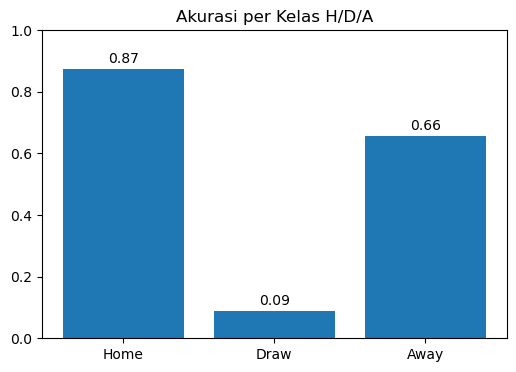

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ---------------------------------------
# asumsi:
#   probs_dc : array Nx3   → prob(H), prob(D), prob(A)
#   y_true   : array str   → ["H","A","D", ...]
# ---------------------------------------

labels = np.array(["H","D","A"])

# argmax → prediksi kelas
y_pred = labels[np.argmax(probs_dc, axis=1)]

# total accuracy
total_acc = accuracy_score(y_true, y_pred)
print("Akurasi total:", total_acc)

# ---------------------------------------
# hitung akurasi per kelas
# ---------------------------------------
def class_accuracy(y_true, y_pred, kelas):
    mask = (y_true == kelas)
    if mask.sum() == 0:
        return np.nan
    return accuracy_score(y_true[mask], y_pred[mask])

acc_home = class_accuracy(y_true, y_pred, "H")
acc_draw = class_accuracy(y_true, y_pred, "D")
acc_away = class_accuracy(y_true, y_pred, "A")

print("Akurasi Home :", acc_home)
print("Akurasi Draw :", acc_draw)
print("Akurasi Away :", acc_away)

# ---------------------------------------
# Plot akurasi per kelas
# ---------------------------------------
kelas   = ["Home", "Draw", "Away"]
nilai   = [acc_home, acc_draw, acc_away]

plt.figure(figsize=(6,4))
plt.bar(kelas, nilai)
plt.ylim(0,1)
plt.title("Akurasi per Kelas H/D/A")

for i, v in enumerate(nilai):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


Jumlah aktual  (H, D, A): [np.int64(982), np.int64(520), np.int64(748)]
Jumlah prediksi (H, D, A): [np.int64(1375), np.int64(107), np.int64(768)]


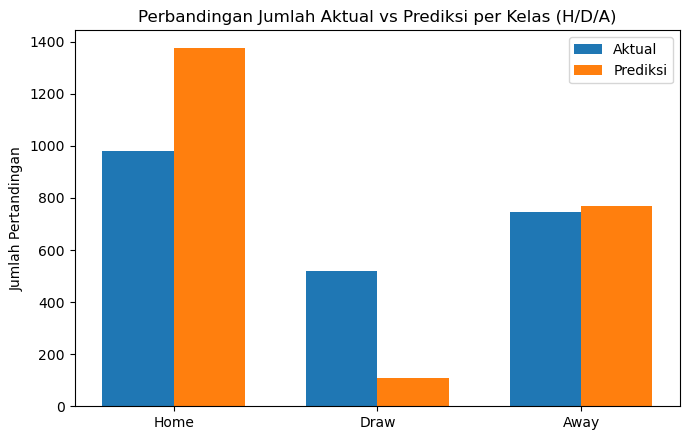

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Asumsi:
#  y_true  → array of "H","D","A"
#  probs_dc → Nx3 probabilitas hasil DC: [pH, pD, pA]
# =========================================================

labels = np.array(["H","D","A"])

# Prediksi kelas via argmax
y_pred = labels[np.argmax(probs_dc, axis=1)]

# Hitung jumlah aktual & prediksi
actual_counts = [np.sum(y_true == lab) for lab in labels]
pred_counts   = [np.sum(y_pred == lab) for lab in labels]

# Tampilkan angka
print("Jumlah aktual  (H, D, A):", actual_counts)
print("Jumlah prediksi (H, D, A):", pred_counts)

# =========================================================
# Plot
# =========================================================
x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(7,4.5))
plt.bar(x - w/2, actual_counts, width=w, label="Aktual")
plt.bar(x + w/2, pred_counts,   width=w, label="Prediksi")

plt.xticks(x, ["Home","Draw","Away"])
plt.ylabel("Jumlah Pertandingan")
plt.title("Perbandingan Jumlah Aktual vs Prediksi per Kelas (H/D/A)")
plt.legend()
plt.tight_layout()
plt.show()


Akurasi total: 0.6195555555555555

Jumlah Aktual per Kelas : {'H': np.int64(982), 'D': np.int64(520), 'A': np.int64(748)}
Jumlah Prediksi Benar    : {'H': np.int64(857), 'D': np.int64(46), 'A': np.int64(491)}


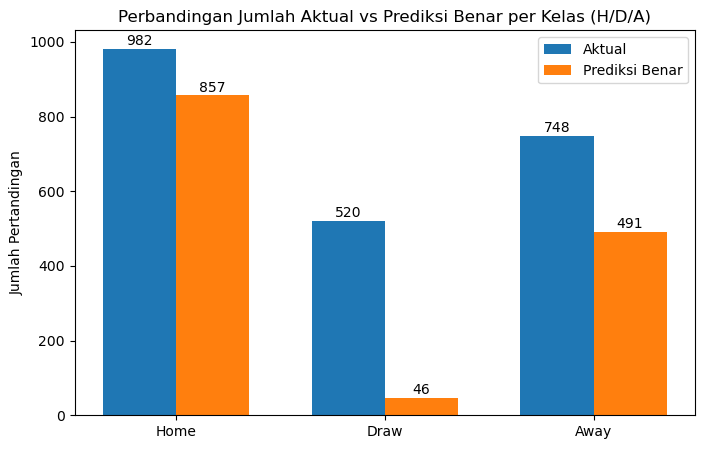

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

labels = np.array(["H","D","A"])

# prediksi kelas dari argmax
y_pred = labels[np.argmax(probs_dc, axis=1)]

# total accuracy
total_acc = accuracy_score(y_true, y_pred)
print("Akurasi total:", total_acc)


# ============================
# HITUNG JUMLAH PER KELAS
# ============================
daftar_kelas = ["H", "D", "A"]

# jumlah aktual (berapa match berlabel H/D/A)
aktual_count = {k: np.sum(y_true == k) for k in daftar_kelas}

# jumlah prediksi benar (true positives per kelas)
benar_count = {k: np.sum((y_true == k) & (y_pred == k)) for k in daftar_kelas}

print("\nJumlah Aktual per Kelas :", aktual_count)
print("Jumlah Prediksi Benar    :", benar_count)


# ============================
# VISUALISASI
# ============================
kelas = ["Home", "Draw", "Away"]
aktual = [aktual_count["H"], aktual_count["D"], aktual_count["A"]]
benar  = [benar_count["H"], benar_count["D"], benar_count["A"]]

x = np.arange(len(kelas))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, aktual, width, label="Aktual", color="tab:blue")
plt.bar(x + width/2, benar,  width, label="Prediksi Benar", color="tab:orange")

plt.xticks(x, kelas)
plt.ylabel("Jumlah Pertandingan")
plt.title("Perbandingan Jumlah Aktual vs Prediksi Benar per Kelas (H/D/A)")
plt.legend()

# tampilkan nilai di atas batang
for i, v in enumerate(aktual):
    plt.text(i - width/2, v + 10, str(v), ha='center')

for i, v in enumerate(benar):
    plt.text(i + width/2, v + 10, str(v), ha='center')

plt.show()
